# F21AA - Coursework 2
## Amazon Reviews
This coursework contains the Amazon food review data set . This data set will only include the review ‘Text’ and the corresponding rating {1,2,3,4,5} provided by the user. This will be used to train models and predict the scores for future reviews.
### Group 3
- Zayan Shameer
- Mohammed Kamel
- Ratish Palanisamy
- Ahmad Meda

### Notebook Link
https://colab.research.google.com/drive/1rMqxfq3J6A7I0R2UfniYjIuVaPEWNwt3?usp=sharing

## Install Necessary Libraries

In [1]:
!pip install datasets catboost transformers gensim pyLDAvis -q

## Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
import shutil
import argparse
import yaml
import numpy as np
import torch

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings

import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.utils import simple_preprocess

from tqdm.auto import tqdm

from transformers import (
    pipeline,
    Trainer, TrainingArguments,
    AutoTokenizer, AutoModelForSequenceClassification,
)


from datasets import load_dataset, Dataset, concatenate_datasets
from huggingface_hub import login

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier

from IPython.display import display
from wordcloud import WordCloud
from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Exploration and Visualization

## Introduction
In this section, we explore the Amazon Reviews dataset, which contains text reviews and corresponding ratings (1 to 5 stars) for Arts and Crafts related products. The main goals of this exploratory analysis are to:
- Understand the overall structure and quality of the data.
- Identify any imbalances or patterns, such as the skewness of ratings.
- Gain insights into review lengths and common word usage.
- Inform the subsequent steps in text processing and modeling.

These are essential to know before we start training our models to acheieve high accuracy.

In [4]:
train = pd.read_csv("/content/drive/MyDrive/F21AA - CW 2 [Amazon Reviews]/train.csv")
test = pd.read_csv("/content/drive/MyDrive/F21AA - CW 2 [Amazon Reviews]/test.csv")

In [5]:
train

Score                                               Text
0           5  I received this product early from the seller!...
1           5  *****<br />Numi's Collection Assortment Melang...
2           5  I was very careful not to overcook this pasta,...
3           5  Buying this multi-pack I was misled by the pic...
4           5  These bars are so good! I loved them warmed up...
...       ...                                                ...
309126      5  My current favorite tea. I had basically given...
309127      5  Growing up in the southwest refried beans were...
309128      3  Like a lot of the gums by Lotte, the flavor do...
309129      5  I trust this brand--the flavors are blended ju...
309130      5  This pepper is great! I was buying McCormick, ...

[309131 rows x 2 columns]

## Understanding the Dataset

In [6]:
train.loc[0]

Score                                                    5
Text     I received this product early from the seller!...
Name: 0, dtype: object

In [7]:
train.loc[0,'Text']

'I received this product early from the seller! They are a very tastey & a Great mid-day snack. I have shared them with my Glutten Free Friends & they will be ordering this product & more very soon.'

In [8]:
test

Id                                               Text
0            0  Fog chaser was the best both in flavor and bod...
1            1  We found this at PF Changs, and it tastes just...
2            2  Not quite a chocolate bar substitute but delic...
3            3  This is not as tasty as Pamela's Almond Biscot...
4            4  <a href="http://www.amazon.com/gp/product/B000...
...        ...                                                ...
119657  119657  These treats are excellent for training. My do...
119658  119658  I had been buying at a store, but they had a h...
119659  119659  I love real Scottish haggis and this brand, th...
119660  119660  We eat a lot of syrup in our house.  My three ...
119661  119661  I buy this to give to my dog.  He needs to los...

[119662 rows x 2 columns]

In [9]:
print("---Training Set Information---")
train.info()

print("---Testing Set Information---")
test.info()

---Training Set Information---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309131 entries, 0 to 309130
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Score   309131 non-null  int64 
 1   Text    309131 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.7+ MB
---Testing Set Information---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119662 entries, 0 to 119661
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      119662 non-null  int64 
 1   Text    119662 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


The train and the test set shows that it has no null or missing values, with the train set having 309k instances and the test set having 119662 instances that we have predict.

## Removing Duplicates from the Dataset

In [10]:
train = train.drop_duplicates(subset=["Text"])
print(train.head())
train.info()

   Score                                               Text
0      5  I received this product early from the seller!...
1      5  *****<br />Numi's Collection Assortment Melang...
2      5  I was very careful not to overcook this pasta,...
3      5  Buying this multi-pack I was misled by the pic...
4      5  These bars are so good! I loved them warmed up...
<class 'pandas.core.frame.DataFrame'>
Index: 308247 entries, 0 to 309130
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Score   308247 non-null  int64 
 1   Text    308247 non-null  object
dtypes: int64(1), object(1)
memory usage: 7.1+ MB


## Removing Stop Words and Cleaning the Data - ML Methods
The cleaning process is critical for effective text analysis when planning to train with ML Models, this helps the model understand better and classify more accurately.

For cleaning we do the following:
- **Lowercasing:** Converting all text to lowercase to ensure consistency.
- **Removing HTML Tags and URLs:** Eliminating any HTML or URL elements using regular expressions.
- **Removing Special Characters and Numbers:** Keeping only alphabetical characters to focus on the text content.
- **Stopword Removal:** Filtering out common words (using NLTK's stopwords) that do not add significant meaning to the analysis.

The cleaning was done in this part of the notebook since we need to work with wordclouds,cleaning makes it easier to understand the output given by wordclouds.

In [11]:
# Loads the stop words
stop_words = set(stopwords.words("english"))

# Converts all comments to str
train["Text"] = train["Text"].astype(str)

# For text Cleaning Function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters and numbers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return " ".join(words)

# Applying the cleaning fn directly to the 'Comments' column
train["Text"] = train["Text"].apply(clean_text)
train.head()

<ipython-input-11-ea5a77b982ea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Text"] = train["Text"].astype(str)
<ipython-input-11-ea5a77b982ea>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Text"] = train["Text"].apply(clean_text)


Score                                               Text
0      5  received product early seller tastey great mid...
1      5  numis collection assortment melange includes h...
2      5  careful overcook pasta making sure take bite e...
3      5  buying multipack misled picture whole hazel nu...
4      5  bars good loved warmed definitely think great ...

In [12]:
train.head(),


(   Score                                               Text
 0      5  received product early seller tastey great mid...
 1      5  numis collection assortment melange includes h...
 2      5  careful overcook pasta making sure take bite e...
 3      5  buying multipack misled picture whole hazel nu...
 4      5  bars good loved warmed definitely think great ...,)

In [13]:
train["Text"][1]

'numis collection assortment melange includes herbal teas caffeinefree also called teasans dry desert lime lime herbal teasan fields gold lemongrass herbal teasan red mellow bush rooibos herbal teasan bushmens brew honeybush herbal teasan simply mint moroccan mint green teas lower caffeine temple heaven gunpowder green tea monkey king jasmine green tea black teas contain caffeine chinese breakfast yunnan black tea smoky tarry lapsang souchong black teathis total nine different teas two tea bags one box numi teas known highquality organic kosher ingredients opinion tastiest best teas ever tried include artificial ingredients flavoringson box manufacturer writes mistcovered mountains sundrenched deserts fertile fields proudly bring tea palette flavors range smooth earthiness light floral scents refreshingly sweet sour notes share recollection ancient one tamed fire water coexist harmoniously steeped gifts nature since distant past people soothed roused healed explored celebrated wonderfu

After cleaning we check if the Dataset is ready for training as shown in the tables above. The cleaned text is then ready for further exploration and feature extraction.


## Exploratory Analysis

### Review Length Analysis
- **Computation of Review Lengths:** The code computes the length of each review in two ways:
  - By counting characters (`Review Size`).
  - By counting the number of words (`review_len`).
- **Visualization:**
  - A **line plot** shows how review lengths vary across the dataset, helping to identify trends and outliers.
  - A **boxplot** visualizes the distribution of review lengths per rating, indicating that reviews associated with higher ratings tend to be longer.
- **Summary Statistics:** The average review length is calculated to provide a baseline metric.

In [54]:
#Store the length of each review in data
avg=[]

for i in train.Text:
  avg.append(len(i))

train['Review Size']=avg
#calculate avg text review size
sum=0
for i in range(len(avg)):
  sum=sum+avg[i]

avgrev= sum/len(avg)
avgrev

<ipython-input-54-0c0266ab1251>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Review Size']=avg


265.0194162473601

In [55]:
train.describe()


Score    Review Size
count  308247.000000  308247.000000
mean        4.180664     265.019416
std         1.311595     268.408344
min         1.000000       5.000000
25%         4.000000     111.000000
50%         5.000000     185.000000
75%         5.000000     321.000000
max         5.000000   14667.000000

In [56]:
train.head()

Score                                               Text  Review Size
0      5  received product early seller tastey great mid...          105
1      5  numis collection assortment melange includes h...         1309
2      5  careful overcook pasta making sure take bite e...          643
3      5  buying multipack misled picture whole hazel nu...          127
4      5  bars good loved warmed definitely think great ...           95

### Rating Distribution
- **Bar Plot:** A bar chart is used to display the frequency of each rating (1 to 5 stars). The chart is annotated with count labels, clearly showing that the dataset is heavily skewed towards 5-star reviews.
- **Pie Chart:** A pie chart further visualizes the percentage distribution of the ratings, reinforcing the observation of skewness.

<ipython-input-57-276671141f77>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['review_len'] = train['Text'].apply(lambda x: len(str(x).split()))


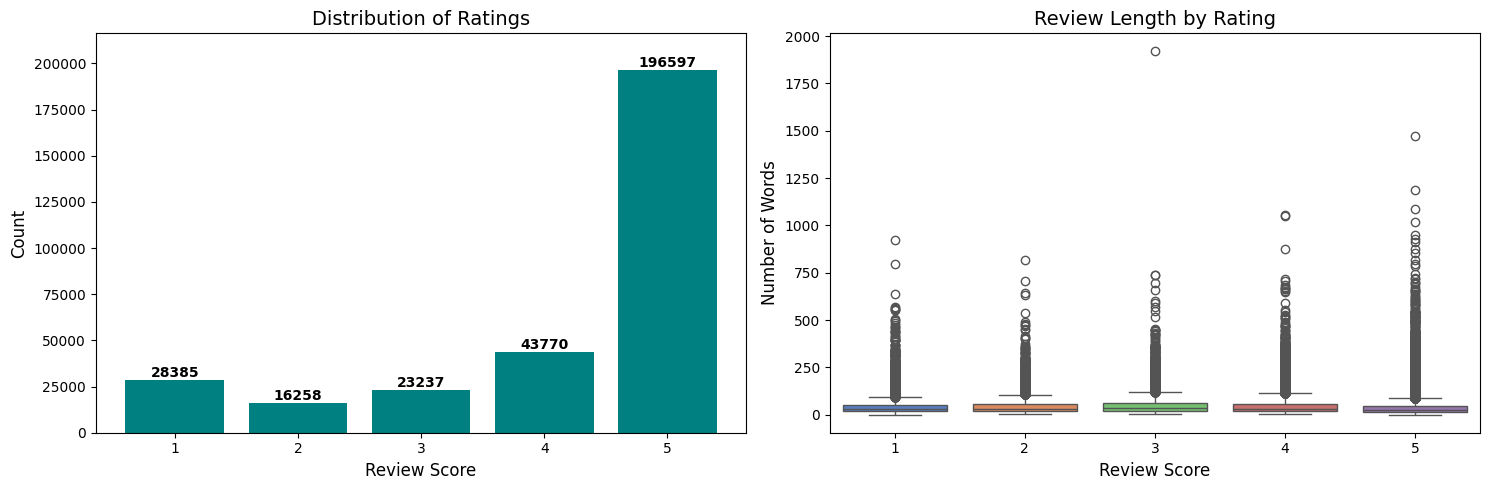

<ipython-input-57-276671141f77>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['review_length'] = train['Text'].apply(lambda x: len(str(x).split()))


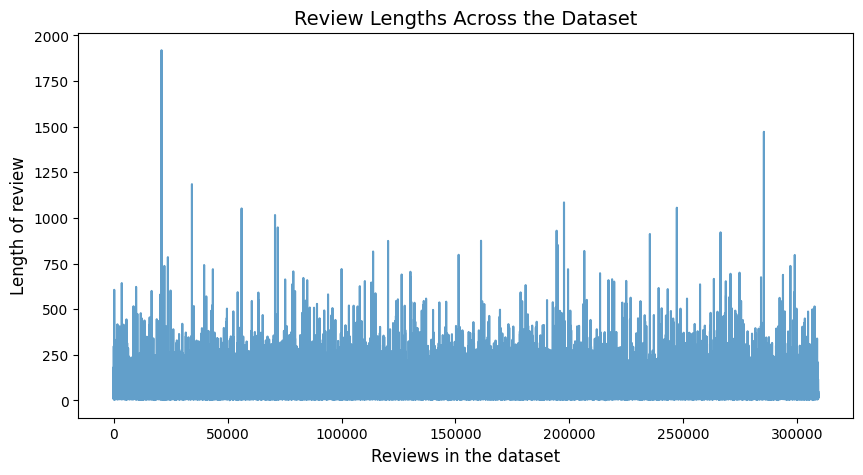

In [57]:
train['review_len'] = train['Text'].apply(lambda x: len(str(x).split()))
score_counts = train['Score'].value_counts().sort_index()
scores = score_counts.index
counts = score_counts.values

fig, axes = plt.subplots(1, 2, figsize=(15,5))  # 1 row, 2 columns
ax1 = axes[0]
bar_plot = ax1.bar(scores, counts, color='#008080')

# Adding count of each rating on the bar
for rect, count_value in zip(bar_plot, counts):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2.0,
             height,
             f'{count_value}',
             ha='center',
             va='bottom',
             fontsize=10,
             color='black',
             fontweight='bold')

ax1.set_title("Distribution of Ratings", fontsize=14)
ax1.set_xlabel("Review Score", fontsize=12)
ax1.set_ylabel("Count", fontsize=12)
ax1.set_ylim([0, max(counts) * 1.1])

# RIGHT PLOT: Boxplot (Review Length by Rating)
ax2 = axes[1]
sns.boxplot(data=train, x='Score', y='review_len', hue='Score', palette="muted", ax=ax2, legend=False)
ax2.set_title("Review Length by Rating", fontsize=14)
ax2.set_xlabel("Review Score", fontsize=12)
ax2.set_ylabel("Number of Words", fontsize=12)

plt.tight_layout()
plt.show()

# Create a new column for review length (word count)
train['review_length'] = train['Text'].apply(lambda x: len(str(x).split()))

# Plot the review length against the review index
plt.figure(figsize=(10,5))
plt.plot(train.index, train['review_length'], linestyle='-', marker='', alpha=0.7)  # Line plot without markers
plt.xlabel("Reviews in the dataset", fontsize=12)
plt.ylabel("Length of review", fontsize=12)
plt.title("Review Lengths Across the Dataset", fontsize=14)
plt.show()


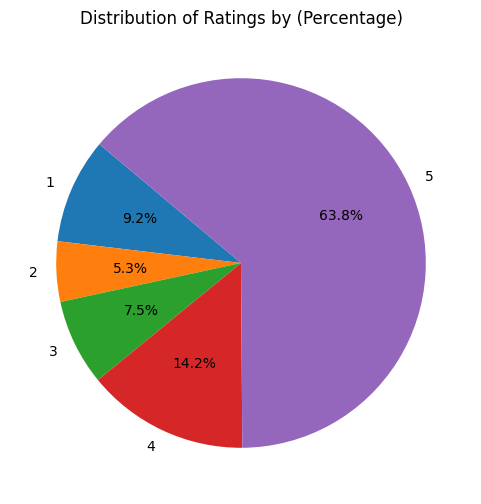

In [ ]:
score_counts = train['Score'].value_counts().sort_index()
scores = score_counts.index
values = score_counts.values

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    values,
    labels=scores,
    autopct='%1.1f%%',  # Percentage
    startangle=140
)
plt.title("Distribution of Ratings by (Percentage)")
plt.show()

As shown in the graphs and the pir chart, our dataset is skewed towards the rating 5 which causes an imbalance. This may cause issues when used in real life problems as not all reviews we take maybe be 5, however this is also may be used to our advantage if the test set if skewed towards the Label 5 as well.

### Word Cloud and Common Words Analysis
- **Overall Word Cloud:** A word cloud is generated from all reviews to identify the most common words used across the dataset.
- **Sentiment-Specific Word Clouds:** Separate word clouds are created for:
  - **Positive Reviews (4-5 Stars)**
  - **Neutral Reviews (3 Stars)**
  - **Negative Reviews (1-2 Stars)**
  
  This helps to visually differentiate the language used in different sentiment categories.

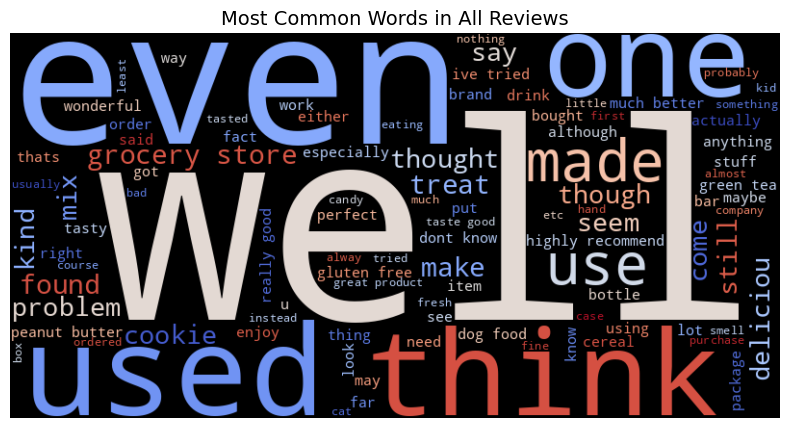

In [ ]:
# Combining reviews into one large text string
all_text = " ".join(str(review) for review in train['Text'])
wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="coolwarm", max_words=100).generate(all_text)


plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Most Common Words in All Reviews", fontsize=14)
plt.show()


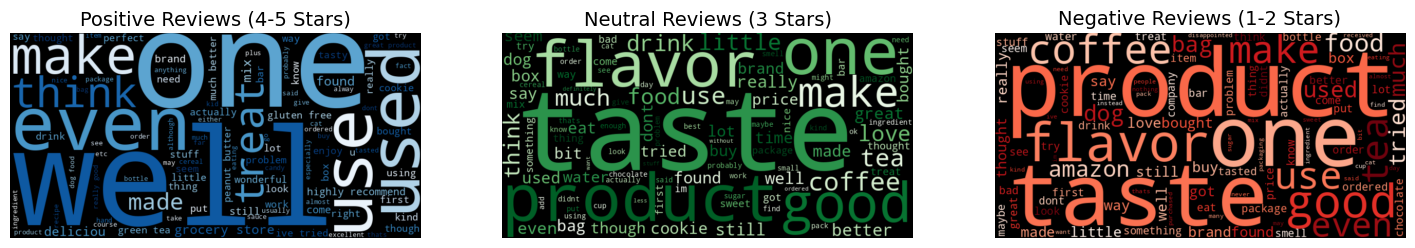

In [ ]:
# Filter text by sentiment category
positive_text = " ".join(str(review) for review in train[train['Score'] >= 4]['Text'])
neutral_text = " ".join(str(review) for review in train[train['Score'] == 3]['Text'])
negative_text = " ".join(str(review) for review in train[train['Score'] <= 2]['Text'])

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Positive Reviews Word Cloud
wordcloud_pos = WordCloud(width=800, height=400, background_color="black", colormap="Blues", max_words=100).generate(positive_text)
axes[0].imshow(wordcloud_pos, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Positive Reviews (4-5 Stars)", fontsize=14)

# Neutral Reviews Word Cloud
wordcloud_neu = WordCloud(width=800, height=400, background_color="black", colormap="Greens", max_words=100).generate(neutral_text)
axes[1].imshow(wordcloud_neu, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Neutral Reviews (3 Stars)", fontsize=14)

# Negative Reviews Word Cloud
wordcloud_neg = WordCloud(width=800, height=400, background_color="black", colormap="Reds", max_words=100).generate(negative_text)
axes[2].imshow(wordcloud_neg, interpolation="bilinear")
axes[2].axis("off")
axes[2].set_title("Negative Reviews (1-2 Stars)", fontsize=14)

plt.show()



- **Top Words Extraction:**
  - Reviews are tokenized (extracting words with at least three letters) and the top 20 most frequent words are computed for each sentiment category.
  - Bar plots are then used to display these frequent words, providing deeper insights into the characteristics of the language in positive, neutral, and negative reviews.

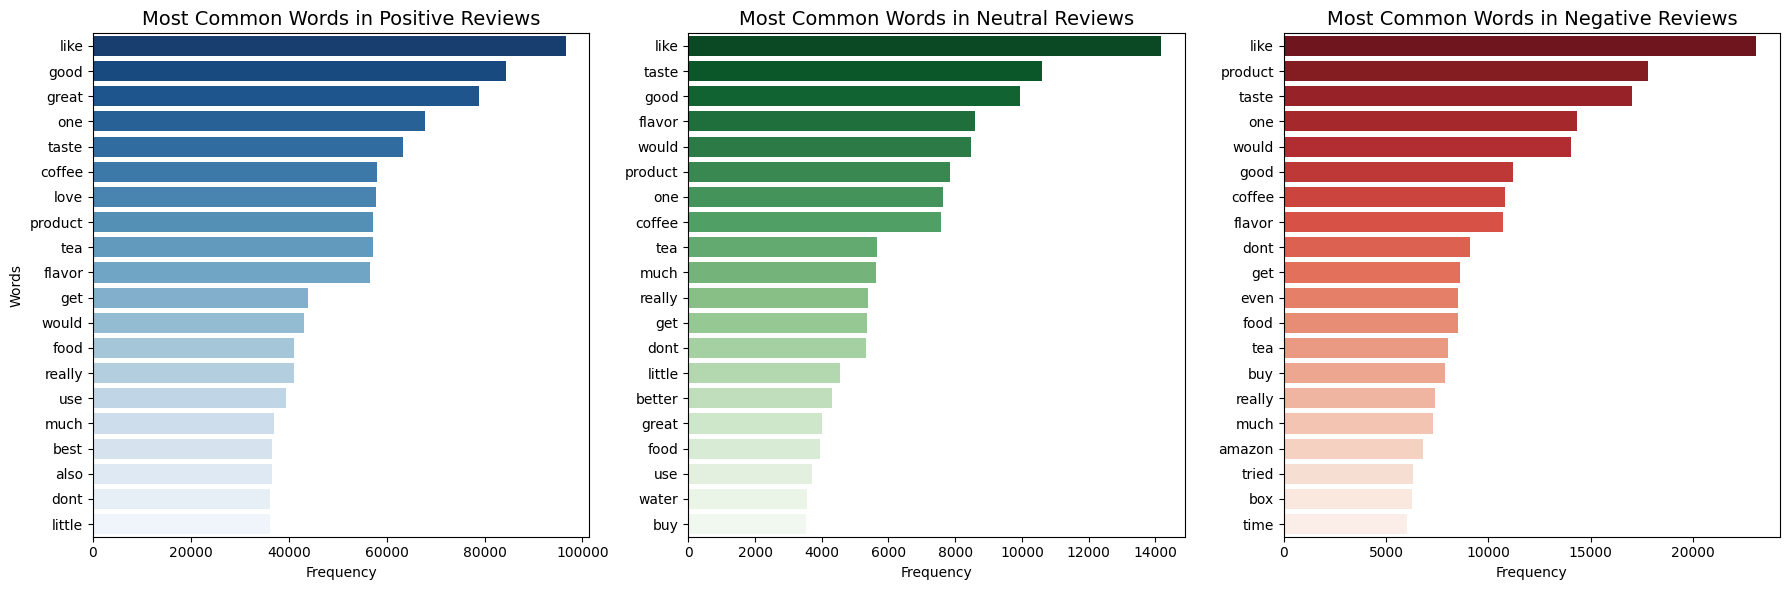

In [ ]:
# Tokenization function
def tokenize(text):
    return re.findall(r'\b[a-zA-Z]{3,}\b', text.lower())  # Extract words with at least 3 letters

# Function to get top words in a category
def get_top_words(text_data, top_n=20):
    words = []
    for review in text_data:
        words.extend(tokenize(str(review)))
    return Counter(words).most_common(top_n)

# Get top 20 words for each sentiment category
top_words_pos = get_top_words(train[train['Score'] >= 4]['Text'])
top_words_neu = get_top_words(train[train['Score'] == 3]['Text'])
top_words_neg = get_top_words(train[train['Score'] <= 2]['Text'])

# Convert to DataFrames
pos_df = pd.DataFrame(top_words_pos, columns=["Word", "Count"])
neu_df = pd.DataFrame(top_words_neu, columns=["Word", "Count"])
neg_df = pd.DataFrame(top_words_neg, columns=["Word", "Count"])

# Create subplots for visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Positive Words
sns.barplot(data=pos_df, y="Word", x="Count", ax=axes[0], hue="Word", palette="Blues_r", legend=False)
axes[0].set_title("Most Common Words in Positive Reviews", fontsize=14)
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Words")

# Plot Neutral Words
sns.barplot(data=neu_df, y="Word", x="Count", ax=axes[1], hue="Word", palette="Greens_r", legend=False)
axes[1].set_title("Most Common Words in Neutral Reviews", fontsize=14)
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("")

# Plot Negative Words
sns.barplot(data=neg_df, y="Word", x="Count", ax=axes[2], hue="Word", palette="Reds_r", legend=False)
axes[2].set_title("Most Common Words in Negative Reviews", fontsize=14)
axes[2].set_xlabel("Frequency")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()


 The word clouds and top words analysis reveal distinct vocabulary trends across different review sentiments, suggesting that text features could be valuable for sentiment classification.

## Discussion After Data Exploration

After conducting an initial exploration of the dataset, several key patterns and insights emerged. In this section, we summarize the findings and discuss the implications for future analysis.

### **Findings from Data Exploration**

1. **Most Common Words in Reviews by Rating**:
   - We observed that the most frequent words in **positive reviews** were terms like "like," "good," "taste," and "coffee," which are strongly associated with positive sentiment.
   - In **neutral reviews**, words like "like," "taste," and "product" were common, but without the same strong sentiment as in the positive reviews.
   - **Negative reviews** frequently mentioned words like "taste," "dont," and "amazon," indicating dissatisfaction or complaints.
   
   These findings highlight the importance of **sentiment-specific keywords** and suggest that models will need to focus on detecting these cues to classify sentiment accurately.

2. **Distribution of Ratings**:
   - The majority of reviews in the dataset are rated **5 stars**, with significantly fewer 1, 2, 3, or 4-star reviews.
   - This imbalance between the classes suggests that models may become biased toward predicting 5-star reviews, which could affect overall model performance.
   - **Action**: We will need to apply **sampling techniques** (e.g., undersampling, oversampling, or class weighting) to handle this imbalance and ensure that the model performs well across all classes.

3. **Review Length by Rating**:
   - A significant pattern observed was that **5-star reviews** tended to be longer, suggesting that customers may provide more detailed feedback when they are satisfied with a product.
   - Conversely, **lower-rated reviews** (1-3 stars) generally contained fewer words, potentially indicating more straightforward or negative feedback.
   - **Action**: **Review length** could be an important feature to include in the model, as longer reviews may have different sentiment patterns compared to shorter ones. We might explore this further to understand its predictive value.

4. **Review Lengths Across the Dataset**:
   - The review lengths showed a wide distribution, with the majority of reviews being relatively short but some exceptionally long ones.
   - **Action**: These outliers could represent highly detailed customer feedback or errors. We should further investigate these outliers to decide whether they should be included in the training data or treated as exceptions.

---

### **Implications for Next Steps**

1. **Handling Imbalanced Data**:
   - Given the heavy skew towards 5-star reviews, **class imbalance** will need to be addressed. This can be done by using **resampling techniques** such as **oversampling** the minority classes (1-4 stars) or **undersampling** the majority class (5 stars).
   - Another approach would be to incorporate **class weighting** in the loss function, so the model gives more importance to the minority classes during training.

2. **Feature Engineering**:
   - The most frequent words in each rating category suggest the importance of focusing on sentiment-specific features. We can apply **n-grams** (unigrams, bigrams, and trigrams) to capture the contextual relationships between words in reviews.
   - **Review length** could be a valuable feature, and it might be worthwhile to investigate its correlation with sentiment ratings further.

3. **Text Preprocessing**:
   - Given the importance of words like "like," "good," "taste," and "amazon," we will need to conduct thorough **text preprocessing**, including **removing stop words**, **stemming**, or **lemmatization** to normalize the text and ensure that meaningful patterns are captured effectively by the model.

4. **Modeling**:
   - We will start with simpler models like **Logistic Regression** and **Naive Bayes**, which are effective for text classification tasks and are relatively quick to train. Based on the results, we may explore more complex models like **Random Forests** or **Gradient Boosting** and eventually experiment with **deep learning** models or **transformers** for more sophisticated text analysis.

5. **Evaluation**:
   - It’s crucial to evaluate model performance using **accuracy**, **precision**, **recall**, and **F1-score**. Given the imbalanced data, special attention will be paid to **F1-scores** and **macro averages** to ensure that the model performs well across all classes, not just the dominant 5-star class.

# Text Processing and Normalization
The text processing and normalization step, as shown in the code above, was essential for preparing the reviews for further analysis, such as generating wordclouds. By converting the text to lowercase, removing HTML tags, URLs, special characters, numbers, and extra spaces, and filtering out stop words, we ensured that only the meaningful content remained. This cleaning process was crucial to reduce noise and inconsistencies in the dataset, allowing us to clearly visualize the most common and relevant words in the wordclouds.

We already cleaned and preprocessed the data for ML Methods above, now we clean and preprocess the data for transformers.  


#### Tranformers - Huggingface
To ease this process we downloaded and saved the dataset in hugging face for easy access and to make sure the dataset we used above for ML models and Transformers do not get mixed up or corrupted which may lead to catastrophic results.

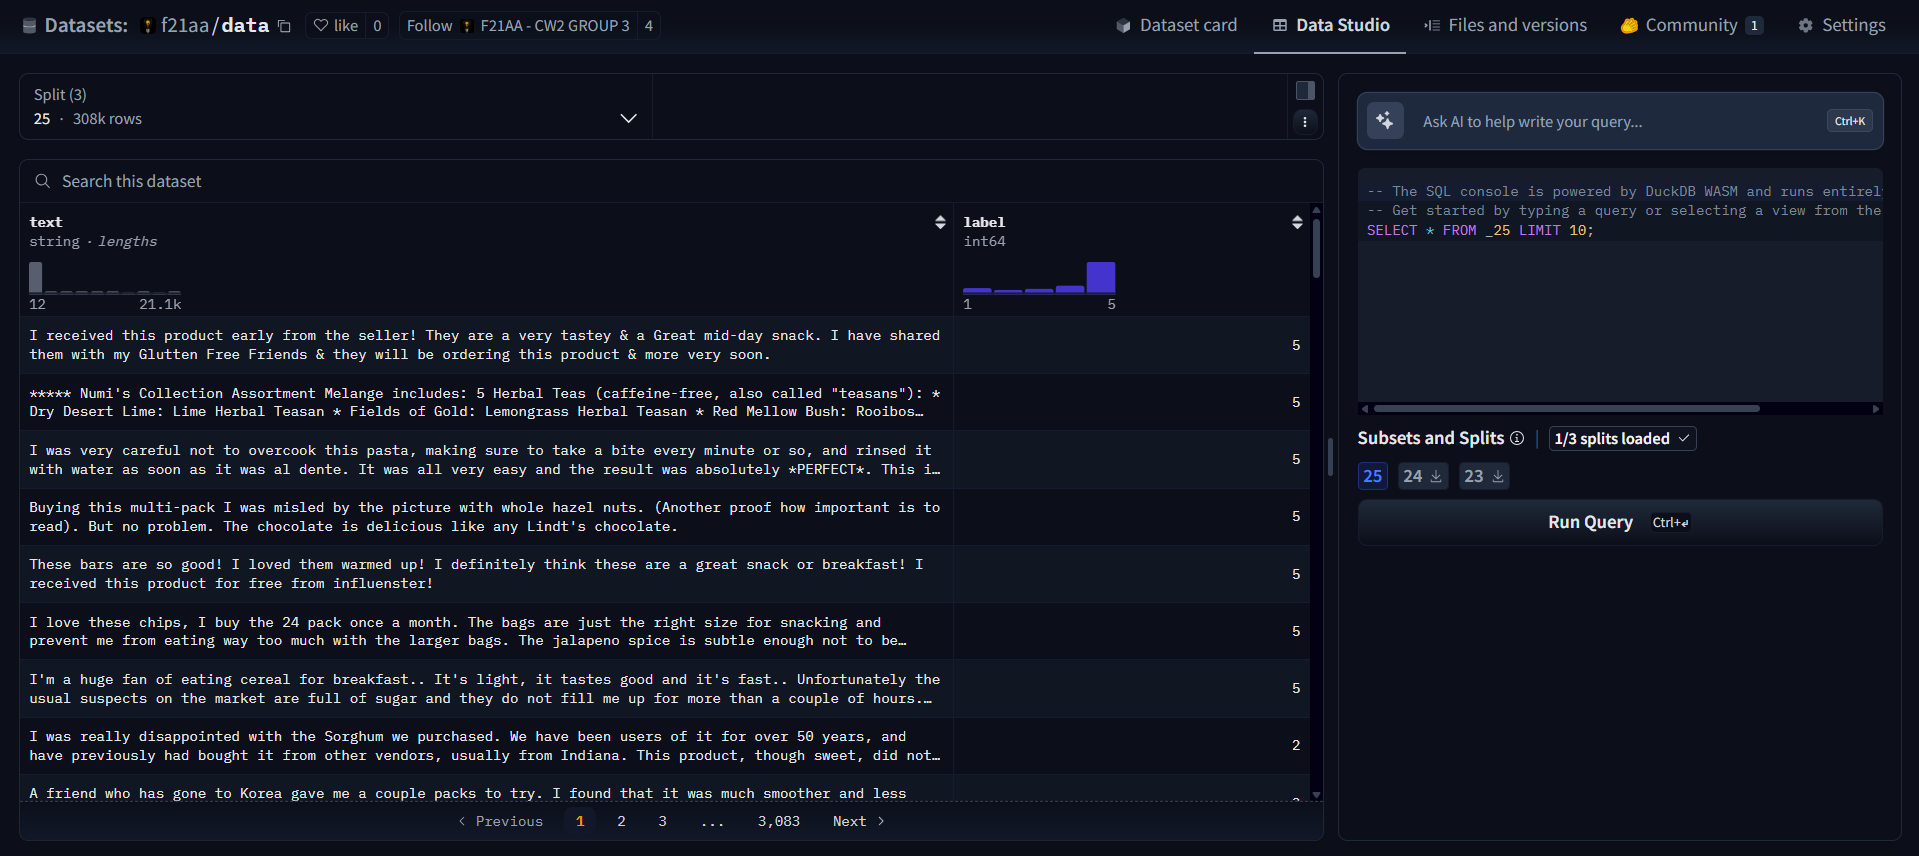

## Cleaning and preprocessing
We clean the data and check for duplicates and then push the dataset to the hugging face hub to train transformers.

### Load Data

In [20]:
data = pd.read_csv('/content/drive/MyDrive/F21AA - CW 2 [Amazon Reviews]/train.csv')

### Text Cleaning for Transformers

When working with transformer models such as BERT or GPT, extensive cleaning of the text is often not required. These models are pre-trained on vast amounts of raw text, which means they are inherently robust to variations in punctuation, casing, and minor formatting inconsistencies. In other words, they have learned to understand context and semantics from text that retains much of its original structure.

In [21]:
data.columns = ['label', 'text']

data = data.dropna()
data = data.drop_duplicates(['text'])

ds = Dataset.from_pandas(data[['text', 'label']].reset_index(drop=True))

def preprocess(example):
    text = example['text'].replace('<br />', '\n')
    text = re.sub(re.compile('<.*?>'), '', text)

    return {'text': text}

ds = ds.map(preprocess)

Map:   0%|          | 0/308247 [00:00<?, ? examples/s]

### Save the dataset at hugging face

In [ ]:
# Push the datset to hub
ds.push_to_hub('f21aa/data', split='25')

We have cleaned and preprocessed the datasets as shown above. We have cleaned the dataset for our ML Model training with a different method compared to the datset we plan on using for transformers,this is becuase of the infrastrcture of the methods used by the models. With this we can say that out datasets have been cleaned and preprocessed.

## Text Normalization for ML Models

### Tokenization

We tokenized the dataset by breaking down the text in the **Text** column into individual tokens. We added a new column to contain the tokenized text of each comment instad of making a new dataset.

**Original Text:**  
`"Natural Language Processing is fun!"`  

**Tokenized Version:**  
`→ ['Natural', 'Language', 'Processing', 'is', 'fun', '!']`

In [14]:
train = train.rename(columns={"Score": "label", "Text": "text"})

In [16]:
train = train.assign(Tokens=lambda x: x.text.astype(str).apply(word_tokenize))
train.head()

label                                               text  \
0      5  received product early seller tastey great mid...   
1      5  numis collection assortment melange includes h...   
2      5  careful overcook pasta making sure take bite e...   
3      5  buying multipack misled picture whole hazel nu...   
4      5  bars good loved warmed definitely think great ...   

                                              Tokens  
0  [received, product, early, seller, tastey, gre...  
1  [numis, collection, assortment, melange, inclu...  
2  [careful, overcook, pasta, making, sure, take,...  
3  [buying, multipack, misled, picture, whole, ha...  
4  [bars, good, loved, warmed, definitely, think,...

### Lemmatization
We use lemmatization to convert words into their base form, known as the **lemma**. This allows us to group different word variations together, making text processing more efficient by reducing complexity and dimensionality.

### 🔹 Example:

**Before Lemmatization:**  
`["running", "flies", "better"]`  

**After Lemmatization:**  
`→ ["run", "fly", "good"]`

In [17]:
lem = WordNetLemmatizer()

def lem_token(tokens):
    return [lem.lemmatize(token) for token in tokens]

# Apply lemmatization directly to the "Tokens" column
train["lem"] = train["Tokens"].apply(lem_token)

train.head()

label                                               text  \
0      5  received product early seller tastey great mid...   
1      5  numis collection assortment melange includes h...   
2      5  careful overcook pasta making sure take bite e...   
3      5  buying multipack misled picture whole hazel nu...   
4      5  bars good loved warmed definitely think great ...   

                                              Tokens  \
0  [received, product, early, seller, tastey, gre...   
1  [numis, collection, assortment, melange, inclu...   
2  [careful, overcook, pasta, making, sure, take,...   
3  [buying, multipack, misled, picture, whole, ha...   
4  [bars, good, loved, warmed, definitely, think,...   

                                                 lem  
0  [received, product, early, seller, tastey, gre...  
1  [numis, collection, assortment, melange, inclu...  
2  [careful, overcook, pasta, making, sure, take,...  
3  [buying, multipack, misled, picture, whole, ha...  
4  [bar, good, loved, warmed, definitely, think, ...

### Stemming

In [18]:
stemmer = PorterStemmer()

def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

train["stemmed"] = train["Tokens"].apply(stem_tokens)
train.head()

label                                               text  \
0      5  received product early seller tastey great mid...   
1      5  numis collection assortment melange includes h...   
2      5  careful overcook pasta making sure take bite e...   
3      5  buying multipack misled picture whole hazel nu...   
4      5  bars good loved warmed definitely think great ...   

                                              Tokens  \
0  [received, product, early, seller, tastey, gre...   
1  [numis, collection, assortment, melange, inclu...   
2  [careful, overcook, pasta, making, sure, take,...   
3  [buying, multipack, misled, picture, whole, ha...   
4  [bars, good, loved, warmed, definitely, think,...   

                                                 lem  \
0  [received, product, early, seller, tastey, gre...   
1  [numis, collection, assortment, melange, inclu...   
2  [careful, overcook, pasta, making, sure, take,...   
3  [buying, multipack, misled, picture, whole, ha...   
4  [bar, good, loved, warmed, definitely, think, ...   

                                             stemmed  
0  [receiv, product, earli, seller, tastey, great...  
1  [numi, collect, assort, melang, includ, herbal...  
2  [care, overcook, pasta, make, sure, take, bite...  
3  [buy, multipack, misl, pictur, whole, hazel, n...  
4  [bar, good, love, warm, definit, think, great,...

## 3. Vector Space Model and Feature Representation - ML Models

In this section, we convert the cleaned text into numerical data that machine learning models can understand. We use a TF-IDF vectorizer to transform the text into a matrix of features. The TF-IDF approach weighs words based on their frequency in a document relative to all documents, and by setting `ngram_range=(1,2,3) and CountVectorizer`, we capture both unigrams (individual words) and bigrams (pairs of words). This combination helps capture more context than using single words alone.

Transformers like BERT and DeBERTa come with pre-trained contextual word embeddings, capturing the semantic meaning of words based on their surrounding context. These embeddings eliminate the need for explicit feature engineering such as n-grams, as they inherently understand word relationships. However, n-grams and word clouds can still be useful for additional exploratory analysis or comparison with traditional methods.


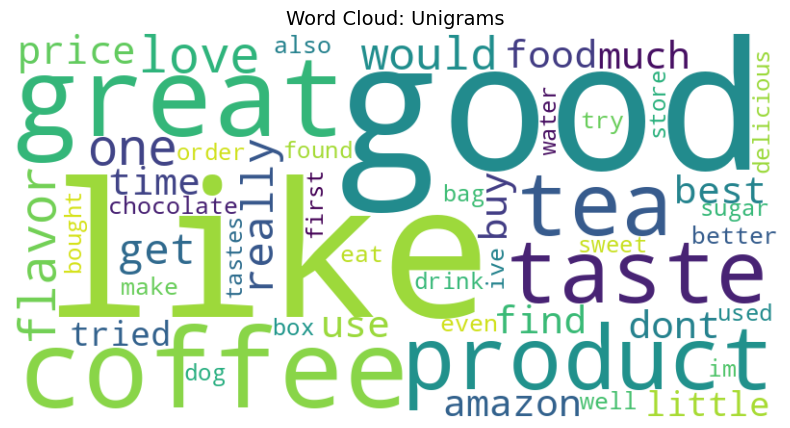

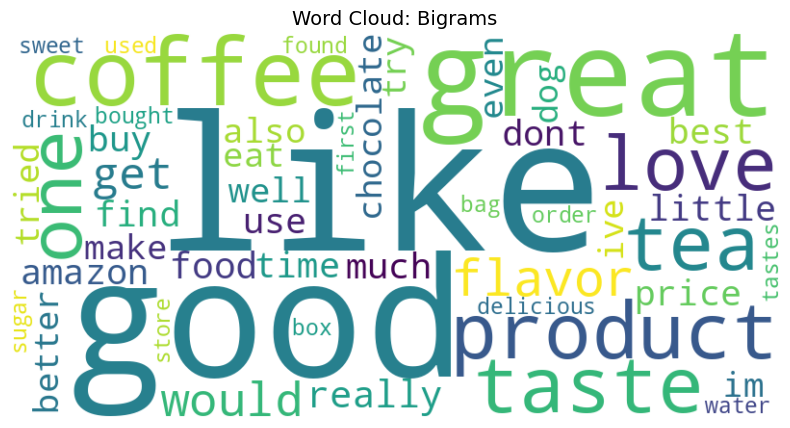

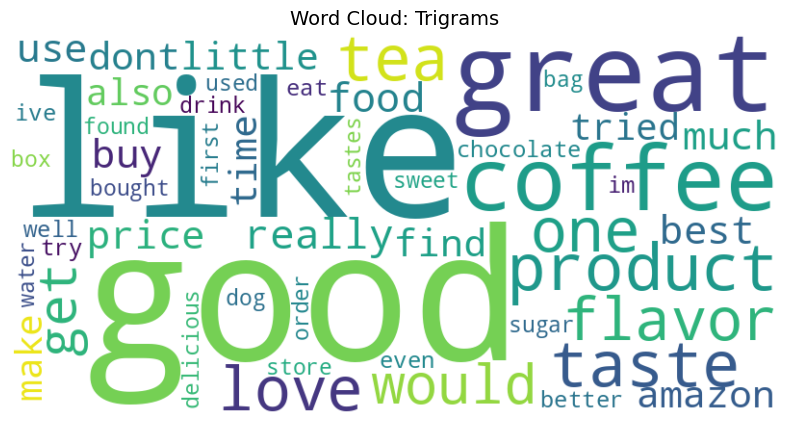

In [17]:
from gensim.downloader import load
texts = train['text']

# Vectorize the entire dataset
# a. TF-IDF Unigram
tfidf_unigram = TfidfVectorizer(max_features=10000, ngram_range=(1,1))
X_tfidf_uni = tfidf_unigram.fit_transform(texts)

# b. TF-IDF Bigram
tfidf_bigram = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_tfidf_bi = tfidf_bigram.fit_transform(texts)

# c. TF-IDF Trigram
tfidf_trigram = TfidfVectorizer(max_features=10000, ngram_range=(1,3))
X_tfidf_tri = tfidf_trigram.fit_transform(texts)

# Function to generate a word cloud
def generate_wordcloud(word_dict, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate_from_frequencies(word_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

# 1. Unigrams
feature_names_uni = tfidf_unigram.get_feature_names_out()
scores_uni = np.asarray(X_tfidf_uni.sum(axis=0)).flatten()
word_dict_uni = dict(zip(feature_names_uni, scores_uni))
generate_wordcloud(word_dict_uni, "Word Cloud: Unigrams")

# 2. Bigrams
feature_names_bi = tfidf_bigram.get_feature_names_out()
scores_bi = np.asarray(X_tfidf_bi.sum(axis=0)).flatten()
word_dict_bi = dict(zip(feature_names_bi, scores_bi))
generate_wordcloud(word_dict_bi, "Word Cloud: Bigrams")

# 3. Trigrams
feature_names_tri = tfidf_trigram.get_feature_names_out()
scores_tri = np.asarray(X_tfidf_tri.sum(axis=0)).flatten()
word_dict_tri = dict(zip(feature_names_tri, scores_tri))
generate_wordcloud(word_dict_tri, "Word Cloud: Trigrams")

[==================================================] 100.0% 66.0/66.0MB downloaded


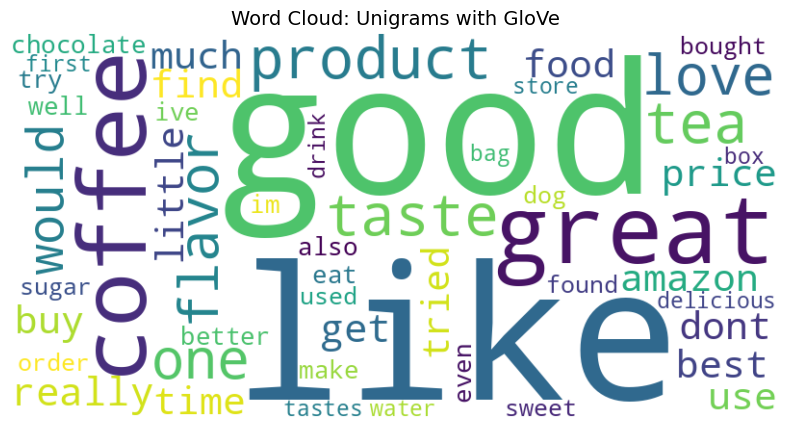

In [16]:
from gensim.downloader import load
# 4. Word Embeddings (GloVe)
glove = load('glove-wiki-gigaword-50')
word_dict_glove = {word: score for word, score in word_dict_uni.items() if word in glove}
generate_wordcloud(word_dict_glove, "Word Cloud: Unigrams with GloVe")

### Split the Data for training and Vectorizations

In [19]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train['text'], train['label'], test_size=0.2, random_state=42, stratify=train['label']
)


### Initialize vectorizers

In [20]:
vectorizations = {}

# a. Default CountVectorizer (Unigrams, limited features)
count_vect = CountVectorizer(max_features=10000)
X_train_counts = count_vect.fit_transform(X_train)
X_val_counts = count_vect.transform(X_val)
vectorizations['Count_Vectorizer'] = (X_train_counts, X_val_counts)

# b. TF-IDF Unigram
tfidf_unigram = TfidfVectorizer(max_features=10000, ngram_range=(1,1))
X_train_tfidf_uni = tfidf_unigram.fit_transform(X_train)
X_val_tfidf_uni = tfidf_unigram.transform(X_val)
vectorizations['TF-IDF_Unigram'] = (X_train_tfidf_uni, X_val_tfidf_uni)

# c. TF-IDF Bigram (includes unigrams and bigrams)
tfidf_bigram = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf_bi = tfidf_bigram.fit_transform(X_train)
X_val_tfidf_bi = tfidf_bigram.transform(X_val)
vectorizations['TF-IDF_Bigram'] = (X_train_tfidf_bi, X_val_tfidf_bi)

# d. TF-IDF Trigram
tfidf_trigram = TfidfVectorizer(max_features=10000, ngram_range=(1,3))
X_train_tfidf_tri = tfidf_trigram.fit_transform(X_train)
X_val_tfidf_tri = tfidf_trigram.transform(X_val)
vectorizations['TF-IDF_Trigram'] = (X_train_tfidf_tri, X_val_tfidf_tri)

# Print shapes to verify
print("\nVectorization Shapes:")
for name, (X_train_vec, X_val_vec) in vectorizations.items():
    print(f"{name} - Training shape: {X_train_vec.shape}, Validation shape: {X_val_vec.shape}")
    print(f"{name} - Training shape: {X_train_vec.shape}, Validation shape: {X_val_vec.shape}")


Vectorization Shapes:
Count_Vectorizer - Training shape: (246597, 10000), Validation shape: (61650, 10000)
Count_Vectorizer - Training shape: (246597, 10000), Validation shape: (61650, 10000)
TF-IDF_Unigram - Training shape: (246597, 10000), Validation shape: (61650, 10000)
TF-IDF_Unigram - Training shape: (246597, 10000), Validation shape: (61650, 10000)
TF-IDF_Bigram - Training shape: (246597, 10000), Validation shape: (61650, 10000)
TF-IDF_Bigram - Training shape: (246597, 10000), Validation shape: (61650, 10000)
TF-IDF_Trigram - Training shape: (246597, 10000), Validation shape: (61650, 10000)
TF-IDF_Trigram - Training shape: (246597, 10000), Validation shape: (61650, 10000)


# 4. Model Training, Selection, Hyperparameter Tuning, and Evaluation

In this section, we define several machine learning models and create an ensemble to improve our classification performance.

## Model Training

In this part of the code, we evaluate multiple classifiers on different vectorization techniques, such as TF-IDF or other methods. The goal is to assess the performance of various models on different feature representations of the text data.

### 1. **Classifiers**:
A dictionary of classifiers is defined, including:
- **SGD Classifier**: A linear model using stochastic gradient descent with the hinge loss, often used for large-scale linear classification.
- **Logistic Regression**: A linear model used for binary or multi-class classification based on the logistic function.
- **Multinomial NB**: Best and fast when used for classification tasks. Works well with text data.

### 2. **Vectorization Techniques**:
The loop iterates over different vectorization techniques (stored in `vectorizations.items()`), applying each technique to the training and validation sets. Vectorization methods convert raw text into numerical features for machine learning algorithms, such as:
- **TF-IDF**: Term Frequency-Inverse Document Frequency, which weighs the importance of words based on their frequency in a document relative to how common they are across all documents.
- **CountVectorizer**: Converts a collection of text documents into a matrix of token counts, representing the frequency of words in the text.
- **Unigrams and Bigrams**: Unigrams refer to single words, while bigrams refer to pairs of consecutive words. In this case, both unigrams and bigrams are extracted from the text to capture more contextual information.

For example, when the text "The quick brown fox" is vectorized:
- **Unigrams**: ["The", "quick", "brown", "fox"]
- **Bigrams**: ["The quick", "quick brown", "brown fox"]

### 3. **Model Training**:
For each vectorization method:
- Each classifier is trained on the transformed training data (`X_train_vec`), corresponding to a specific vectorization technique.
- The classifier is then evaluated on the validation set (`X_val_vec`).

### 4. **Performance Evaluation**:
- **Accuracy Score**: The proportion of correct predictions made by the classifier. It is a simple measure of the model's overall performance.
- **Classification Report**: Provides detailed metrics such as precision, recall, F1-score, and support for each class. These metrics help evaluate the model's performance beyond just accuracy, especially in cases where class imbalances exist.

In [33]:
# Define classifiers
classifiers = {
    "SGD": SGDClassifier(loss='hinge', class_weight='balanced', max_iter=1000, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "MultinomialNB": MultinomialNB()
}

results = {}
classification_reports = {}

# Iterate over vectorizations
for vec_name, (X_train_vec, X_val_vec) in vectorizations.items():
    print(f"\n=== Vectorization Technique: {vec_name} ===")
    results[vec_name] = {}
    classification_reports[vec_name] = {}

    for clf_name, clf in classifiers.items():
        print(f"\nTraining {clf_name} on {vec_name} representation...")
        clf.fit(X_train_vec, y_train)
        y_pred = clf.predict(X_val_vec)
        acc = accuracy_score(y_val, y_pred)

        print(f"{clf_name} Accuracy: {acc:.4f}")
        print("Classification Report:")
        report = classification_report(y_val, y_pred, output_dict=True)


        results[vec_name][clf_name] = acc
        classification_reports[vec_name][clf_name] = report

    print("-" * 50)
accuracy_df = pd.DataFrame(results)

In [32]:
print("\nSummary of Individual Model Accuracy Scores:")
display(accuracy_df)

for vec_name, report_dict in classification_reports.items():
    print(f"\n=== Classification Reports for {vec_name} ===")
    for clf_name, report in report_dict.items():

        report_df = pd.DataFrame(report).transpose()
        print(f"\n{clf_name} Classification Report:")
        display(report_df)
        print("-" * 50)


Summary of Individual Model Accuracy Scores:


Count_Vectorizer  TF-IDF_Unigram  TF-IDF_Bigram  \
SGD                         0.688402        0.687461       0.697015   
LogisticRegression          0.605969        0.614031       0.626294   
MultinomialNB               0.675994        0.669084       0.687802   

                    TF-IDF_Trigram  
SGD                       0.696869  
LogisticRegression        0.626975  
MultinomialNB             0.688078


=== Classification Reports for Count_Vectorizer ===

SGD Classification Report:


precision    recall  f1-score       support
1              0.525777  0.697023  0.599409   5677.000000
2              0.222741  0.293358  0.253218   3252.000000
3              0.295278  0.318915  0.306642   4647.000000
4              0.428635  0.219899  0.290676   8754.000000
5              0.846049  0.867803  0.856788  39320.000000
accuracy       0.688402  0.688402  0.688402      0.688402
macro avg      0.463696  0.479400  0.461347  61650.000000
weighted avg   0.682892  0.688402  0.679396  61650.000000

--------------------------------------------------

LogisticRegression Classification Report:


precision    recall  f1-score       support
1              0.503994  0.611238  0.552460   5677.000000
2              0.195609  0.331488  0.246034   3252.000000
3              0.245930  0.341295  0.285869   4647.000000
4              0.308812  0.416724  0.354743   8754.000000
5              0.889778  0.701322  0.784390  39320.000000
accuracy       0.605969  0.605969  0.605969      0.605969
macro avg      0.428825  0.480414  0.444699  61650.000000
weighted avg   0.686611  0.605969  0.636050  61650.000000

--------------------------------------------------

MultinomialNB Classification Report:


precision    recall  f1-score       support
1              0.498683  0.633785  0.558176   5677.000000
2              0.261647  0.215867  0.236563   3252.000000
3              0.318436  0.257586  0.284797   4647.000000
4              0.364299  0.308202  0.333911   8754.000000
5              0.824895  0.851475  0.837974  39320.000000
accuracy       0.675994  0.675994  0.675994      0.675994
macro avg      0.453592  0.453383  0.450284  61650.000000
weighted avg   0.661567  0.675994  0.667214  61650.000000

--------------------------------------------------

=== Classification Reports for TF-IDF_Unigram ===

SGD Classification Report:


precision    recall  f1-score       support
1              0.449654  0.800775  0.575917   5677.000000
2              0.196689  0.186347  0.191378   3252.000000
3              0.290632  0.267054  0.278345   4647.000000
4              0.498821  0.048321  0.088107   8754.000000
5              0.820609  0.904527  0.860527  39320.000000
accuracy       0.687461  0.687461  0.687461      0.687461
macro avg      0.451281  0.441405  0.398855  61650.000000
weighted avg   0.667898  0.687461  0.645458  61650.000000

--------------------------------------------------

LogisticRegression Classification Report:


precision    recall  f1-score       support
1              0.524290  0.640655  0.576661   5677.000000
2              0.218121  0.363469  0.272633   3252.000000
3              0.268454  0.374866  0.312859   4647.000000
4              0.314211  0.441741  0.367219   8754.000000
5              0.899305  0.697533  0.785671  39320.000000
accuracy       0.614031  0.614031  0.614031      0.614031
macro avg      0.444876  0.503653  0.463009  61650.000000
weighted avg   0.698208  0.614031  0.644305  61650.000000

--------------------------------------------------

MultinomialNB Classification Report:


precision    recall  f1-score       support
1              0.678480  0.327109  0.441407   5677.000000
2              0.388889  0.002153  0.004281   3252.000000
3              0.355000  0.015279  0.029296   4647.000000
4              0.414702  0.034156  0.063113   8754.000000
5              0.672974  0.992243  0.802002  39320.000000
accuracy       0.669084  0.669084  0.669084      0.669084
macro avg      0.502009  0.274188  0.268020  61650.000000
weighted avg   0.597854  0.669084  0.563555  61650.000000

--------------------------------------------------

=== Classification Reports for TF-IDF_Bigram ===

SGD Classification Report:


precision    recall  f1-score       support
1              0.465301  0.792496  0.586342   5677.000000
2              0.229084  0.212177  0.220307   3252.000000
3              0.313665  0.285991  0.299190   4647.000000
4              0.548891  0.076308  0.133989   8754.000000
5              0.822360  0.910097  0.864007  39320.000000
accuracy       0.697015  0.697015  0.697015      0.697015
macro avg      0.475860  0.455414  0.420767  61650.000000
weighted avg   0.681010  0.697015  0.658250  61650.000000

--------------------------------------------------

LogisticRegression Classification Report:


precision    recall  f1-score       support
1              0.539495  0.636428  0.583966   5677.000000
2              0.232759  0.373616  0.286827   3252.000000
3              0.284050  0.393587  0.329966   4647.000000
4              0.320998  0.446881  0.373621   8754.000000
5              0.901469  0.713174  0.796342  39320.000000
accuracy       0.626294  0.626294  0.626294      0.626294
macro avg      0.455754  0.512737  0.474145  61650.000000
weighted avg   0.703900  0.626294  0.654731  61650.000000

--------------------------------------------------

MultinomialNB Classification Report:


precision    recall  f1-score       support
1              0.658576  0.425401  0.516909   5677.000000
2              0.463415  0.017528  0.033778   3252.000000
3              0.456621  0.064558  0.113122   4647.000000
4              0.508156  0.092529  0.156552   8754.000000
5              0.698106  0.987309  0.817895  39320.000000
accuracy       0.687802  0.687802  0.687802      0.687802
macro avg      0.556975  0.317465  0.327651  61650.000000
weighted avg   0.636912  0.687802  0.601786  61650.000000

--------------------------------------------------

=== Classification Reports for TF-IDF_Trigram ===

SGD Classification Report:


precision    recall  f1-score       support
1              0.464977  0.791615  0.585843   5677.000000
2              0.227227  0.209410  0.217955   3252.000000
3              0.312204  0.284054  0.297465   4647.000000
4              0.549837  0.076879  0.134897   8754.000000
5              0.822170  0.910326  0.864005  39320.000000
accuracy       0.696869  0.696869  0.696869      0.696869
macro avg      0.475283  0.454457  0.420033  61650.000000
weighted avg   0.680786  0.696869  0.658078  61650.000000

--------------------------------------------------

LogisticRegression Classification Report:


precision    recall  f1-score       support
1              0.540146  0.638718  0.585311   5677.000000
2              0.232840  0.372386  0.286525   3252.000000
3              0.284318  0.394448  0.330449   4647.000000
4              0.322327  0.449395  0.375400   8754.000000
5              0.902361  0.713352  0.796801  39320.000000
accuracy       0.626975  0.626975  0.626975      0.626975
macro avg      0.456398  0.513660  0.474897  61650.000000
weighted avg   0.704742  0.626975  0.655420  61650.000000

--------------------------------------------------

MultinomialNB Classification Report:


precision    recall  f1-score       support
1              0.653398  0.425048  0.515048   5677.000000
2              0.489933  0.022448  0.042929   3252.000000
3              0.457227  0.066710  0.116432   4647.000000
4              0.505796  0.094700  0.159530   8754.000000
5              0.699122  0.986648  0.818365  39320.000000
accuracy       0.688078  0.688078  0.688078      0.688078
macro avg      0.561095  0.319111  0.330461  61650.000000
weighted avg   0.638193  0.688078  0.603069  61650.000000

--------------------------------------------------


<ipython-input-34-1501865723b2>:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted_df, x="Vectorization", y="Score", hue="Metric", ci=None)


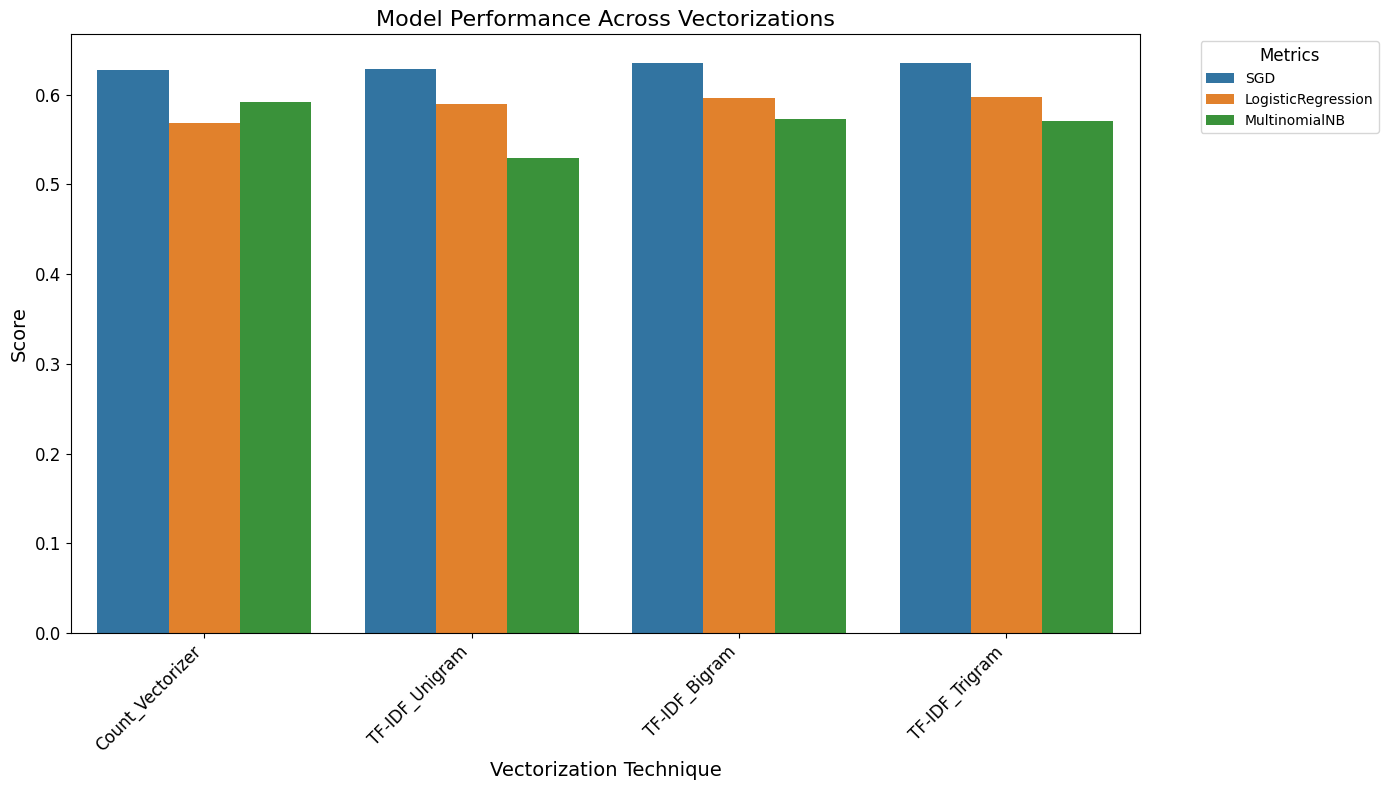

In [34]:
plt.show()


## Model Training With GridSearch Cross-Validation

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
classifiers = {
    "SGD": Pipeline([('clf', SGDClassifier(class_weight='balanced', max_iter=1000, random_state=42))]),
    "LogisticRegression": Pipeline([('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))]),
    "MultinomialNB": Pipeline([('clf', MultinomialNB())])
}

# Hyperparameter grids for each classifier
param_grids = {
    "SGD": {
        'clf__loss': ['hinge', 'log_loss'],
        'clf__alpha': [0.0001, 0.001],
    },
    "LogisticRegression": {
        'clf__C': [0.1, 1, 10],
        'clf__penalty': ['l2'],
    },
    "MultinomialNB": {
        'clf__alpha': [0.1, 1.0, 2.0]
    }
}

results = {}
classification_reports = {}
best_params = {}

# Iterate over vectorizations
for vec_name, (X_train_vec, X_val_vec) in vectorizations.items():
    print(f"\n=== Vectorization Technique: {vec_name} ===")
    results[vec_name] = {}
    classification_reports[vec_name] = {}
    best_params[vec_name] = {}

    for clf_name, clf in classifiers.items():
        print(f"\nTuning {clf_name} on {vec_name} representation with Cross-Validation...")

        grid_search = GridSearchCV(
            clf,
            param_grids[clf_name],
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )
        grid_search.fit(X_train_vec, y_train)

        # Store the best parameters
        best_params[vec_name][clf_name] = grid_search.best_params_
        print(f"Best Parameters for {clf_name}: {grid_search.best_params_}")
        print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

        # Use the best model to predict on validation set
        y_pred = grid_search.best_estimator_.predict(X_val_vec)
        acc = accuracy_score(y_val, y_pred)
        print(f"{clf_name} Validation Accuracy: {acc:.4f}")
        print("Classification Report:")
        report = classification_report(y_val, y_pred, output_dict=True)

        results[vec_name][clf_name] = acc
        classification_reports[vec_name][clf_name] = report

    print("-" * 50)

# Display accuracy scores in a table
accuracy_df = pd.DataFrame(results)


=== Vectorization Technique: Count_Vectorizer ===

Tuning SGD on Count_Vectorizer representation with Cross-Validation...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters for SGD: {'clf__alpha': 0.001, 'clf__loss': 'log_loss'}
Best Cross-Validation Accuracy: 0.7009
SGD Validation Accuracy: 0.7026
Classification Report:

Tuning LogisticRegression on Count_Vectorizer representation with Cross-Validation...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters for LogisticRegression: {'clf__C': 0.1, 'clf__penalty': 'l2'}
Best Cross-Validation Accuracy: 0.6184
LogisticRegression Validation Accuracy: 0.6208
Classification Report:

Tuning MultinomialNB on Count_Vectorizer representation with Cross-Validation...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters for MultinomialNB: {'clf__alpha': 2.0}
Best Cross-Validation Accuracy: 0.6720
MultinomialNB Validation Accuracy: 0.6762
Classification Report:
----------------

In [61]:
print("\nSummary of Individual Model Accuracy Scores:")
display(accuracy_df)

for vec_name, report_dict in classification_reports.items():
    print(f"\n=== Classification Reports for {vec_name} ===")
    for clf_name, report in report_dict.items():
        report_df = pd.DataFrame(report).transpose()
        print(f"\n{clf_name} Classification Report:")
        display(report_df)
        print("-" * 50)

print("\nBest Parameters for Each Model and Vectorization:")
for vec_name, params_dict in best_params.items():
    print(f"\n{vec_name}:")
    for clf_name, params in params_dict.items():
        print(f"  {clf_name}: {params}")


Summary of Individual Model Accuracy Scores:


Count_Vectorizer  TF-IDF_Unigram  TF-IDF_Bigram  \
SGD                         0.702644        0.704428       0.708613   
LogisticRegression          0.620811        0.619351       0.630527   
MultinomialNB               0.676204        0.672733       0.691030   

                    TF-IDF_Trigram  
SGD                       0.708694  
LogisticRegression        0.630041  
MultinomialNB             0.691549


=== Classification Reports for Count_Vectorizer ===

SGD Classification Report:


precision    recall  f1-score       support
1              0.542294  0.659503  0.595183   5677.000000
2              0.263263  0.244157  0.253350   3252.000000
3              0.354389  0.278890  0.312139   4647.000000
4              0.453190  0.249943  0.322191   8754.000000
5              0.816187  0.897660  0.854987  39320.000000
accuracy       0.702644  0.702644  0.702644      0.702644
macro avg      0.485864  0.466031  0.467570  61650.000000
weighted avg   0.675446  0.702644  0.682754  61650.000000

--------------------------------------------------

LogisticRegression Classification Report:


precision    recall  f1-score       support
1              0.519454  0.637308  0.572378   5677.000000
2              0.211254  0.347478  0.262760   3252.000000
3              0.266613  0.354853  0.304468   4647.000000
4              0.320944  0.424149  0.365399   8754.000000
5              0.891742  0.716251  0.794420  39320.000000
accuracy       0.620811  0.620811  0.620811      0.620811
macro avg      0.442002  0.496008  0.459885  61650.000000
weighted avg   0.693394  0.620811  0.648079  61650.000000

--------------------------------------------------

MultinomialNB Classification Report:


precision    recall  f1-score       support
1              0.497460  0.638189  0.559105   5677.000000
2              0.259186  0.201722  0.226872   3252.000000
3              0.319023  0.255864  0.283974   4647.000000
4              0.365013  0.308430  0.334345   8754.000000
5              0.823344  0.852492  0.837665  39320.000000
accuracy       0.676204  0.676204  0.676204      0.676204
macro avg      0.452805  0.451340  0.448392  61650.000000
weighted avg   0.660481  0.676204  0.666590  61650.000000

--------------------------------------------------

=== Classification Reports for TF-IDF_Unigram ===

SGD Classification Report:


precision    recall  f1-score       support
1              0.548068  0.644707  0.592473   5677.000000
2              0.275934  0.242927  0.258381   3252.000000
3              0.351535  0.300624  0.324092   4647.000000
4              0.465340  0.243089  0.319352   8754.000000
5              0.813852  0.901653  0.855505  39320.000000
accuracy       0.704428  0.704428  0.704428      0.704428
macro avg      0.490946  0.466600  0.469961  61650.000000
weighted avg   0.676667  0.704428  0.683599  61650.000000

--------------------------------------------------

LogisticRegression Classification Report:


precision    recall  f1-score       support
1              0.499737  0.668311  0.571859   5677.000000
2              0.224896  0.365006  0.278312   3252.000000
3              0.293971  0.379815  0.331424   4647.000000
4              0.321891  0.440256  0.371882   8754.000000
5              0.895465  0.701501  0.786703  39320.000000
accuracy       0.619351  0.619351  0.619351      0.619351
macro avg      0.447192  0.510978  0.468036  61650.000000
weighted avg   0.696869  0.619351  0.646882  61650.000000

--------------------------------------------------

MultinomialNB Classification Report:


precision    recall  f1-score       support
1              0.678523  0.352827  0.464248   5677.000000
2              0.370968  0.007073  0.013881   3252.000000
3              0.371622  0.023671  0.044507   4647.000000
4              0.428571  0.038725  0.071032   8754.000000
5              0.677666  0.991836  0.805191  39320.000000
accuracy       0.672733  0.672733  0.672733      0.672733
macro avg      0.505470  0.282826  0.279772  61650.000000
weighted avg   0.603128  0.672733  0.570469  61650.000000

--------------------------------------------------

=== Classification Reports for TF-IDF_Bigram ===

SGD Classification Report:


precision    recall  f1-score       support
1              0.560162  0.633081  0.594393   5677.000000
2              0.290909  0.250923  0.269440   3252.000000
3              0.359109  0.308801  0.332061   4647.000000
4              0.474391  0.242289  0.320756   8754.000000
5              0.812520  0.908444  0.857808  39320.000000
accuracy       0.708613  0.708613  0.708613      0.708613
macro avg      0.499418  0.468708  0.474892  61650.000000
weighted avg   0.679578  0.708613  0.686628  61650.000000

--------------------------------------------------

LogisticRegression Classification Report:


precision    recall  f1-score       support
1              0.518652  0.661265  0.581340   5677.000000
2              0.243132  0.380996  0.296838   3252.000000
3              0.304142  0.387131  0.340655   4647.000000
4              0.328942  0.450651  0.380296   8754.000000
5              0.895791  0.715539  0.795583  39320.000000
accuracy       0.630527  0.630527  0.630527      0.630527
macro avg      0.458132  0.519117  0.478942  61650.000000
weighted avg   0.701548  0.630527  0.656286  61650.000000

--------------------------------------------------

MultinomialNB Classification Report:


precision    recall  f1-score      support
1              0.654900  0.437907  0.524860   5677.00000
2              0.448980  0.033825  0.062911   3252.00000
3              0.463263  0.080052  0.136514   4647.00000
4              0.510889  0.099155  0.166077   8754.00000
5              0.703468  0.985910  0.821079  39320.00000
accuracy       0.691030  0.691030  0.691030      0.69103
macro avg      0.556300  0.327370  0.342288  61650.00000
weighted avg   0.640120  0.691030  0.609201  61650.00000

--------------------------------------------------

=== Classification Reports for TF-IDF_Trigram ===

SGD Classification Report:


precision    recall  f1-score       support
1              0.559607  0.632552  0.593848   5677.000000
2              0.293490  0.253690  0.272143   3252.000000
3              0.359850  0.310523  0.333372   4647.000000
4              0.473943  0.242061  0.320454   8754.000000
5              0.812749  0.908266  0.857857  39320.000000
accuracy       0.708694  0.708694  0.708694      0.708694
macro avg      0.499928  0.469418  0.475535  61650.000000
weighted avg   0.679801  0.708694  0.686807  61650.000000

--------------------------------------------------

LogisticRegression Classification Report:


precision    recall  f1-score       support
1              0.516970  0.660032  0.579807   5677.000000
2              0.243482  0.381919  0.297378   3252.000000
3              0.304134  0.386271  0.340317   4647.000000
4              0.328223  0.449966  0.379571   8754.000000
5              0.895567  0.715132  0.795243  39320.000000
accuracy       0.630041  0.630041  0.630041      0.630041
macro avg      0.457675  0.518664  0.478463  61650.000000
weighted avg   0.701166  0.630041  0.655828  61650.000000

--------------------------------------------------

MultinomialNB Classification Report:


precision    recall  f1-score       support
1              0.652083  0.438436  0.524331   5677.000000
2              0.448276  0.039975  0.073405   3252.000000
3              0.459295  0.081343  0.138208   4647.000000
4              0.509972  0.102239  0.170330   8754.000000
5              0.704849  0.985300  0.821806  39320.000000
accuracy       0.691549  0.691549  0.691549      0.691549
macro avg      0.554895  0.329459  0.345616  61650.000000
weighted avg   0.640275  0.691549  0.610902  61650.000000

--------------------------------------------------

Best Parameters for Each Model and Vectorization:

Count_Vectorizer:
  SGD: {'clf__alpha': 0.001, 'clf__loss': 'log_loss'}
  LogisticRegression: {'clf__C': 0.1, 'clf__penalty': 'l2'}
  MultinomialNB: {'clf__alpha': 2.0}

TF-IDF_Unigram:
  SGD: {'clf__alpha': 0.0001, 'clf__loss': 'log_loss'}
  LogisticRegression: {'clf__C': 0.1, 'clf__penalty': 'l2'}
  MultinomialNB: {'clf__alpha': 0.1}

TF-IDF_Bigram:
  SGD: {'clf__alpha': 0.0001, 'clf__loss': 'log_loss'}
  LogisticRegression: {'clf__C': 0.1, 'clf__penalty': 'l2'}
  MultinomialNB: {'clf__alpha': 0.1}

TF-IDF_Trigram:
  SGD: {'clf__alpha': 0.0001, 'clf__loss': 'log_loss'}
  LogisticRegression: {'clf__C': 0.1, 'clf__penalty': 'l2'}
  MultinomialNB: {'clf__alpha': 0.1}


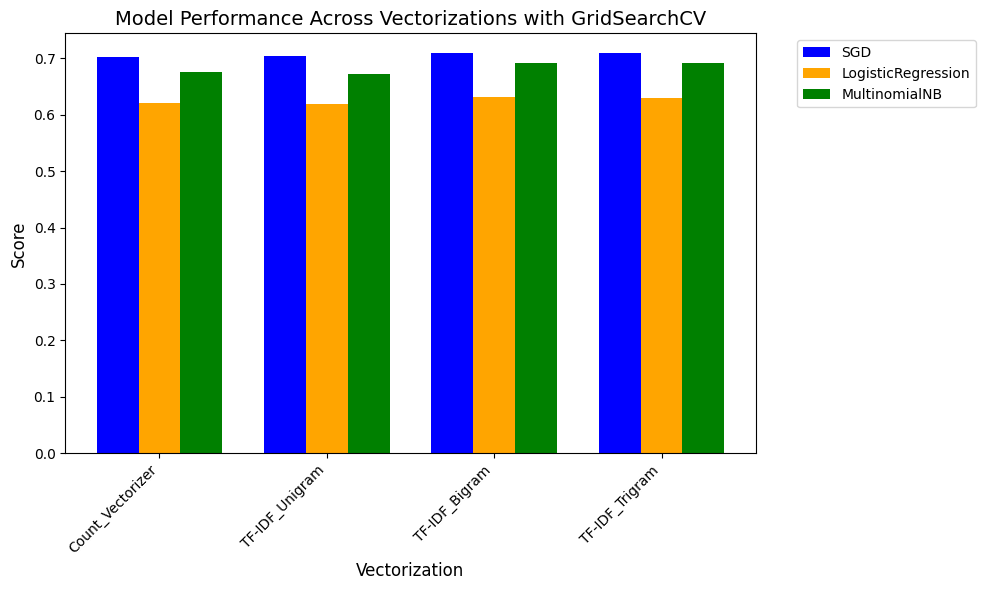

In [62]:
results_df = pd.DataFrame(results).T
models = ['SGD', 'LogisticRegression', 'MultinomialNB']
vectorizations = results_df.index

bar_width = 0.25
x = np.arange(len(vectorizations))
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, results_df['SGD'], bar_width, label='SGD', color='blue')
plt.bar(x, results_df['LogisticRegression'], bar_width, label='LogisticRegression', color='orange')
plt.bar(x + bar_width, results_df['MultinomialNB'], bar_width, label='MultinomialNB', color='green')

plt.title('Model Performance Across Vectorizations with GridSearchCV', fontsize=14)
plt.xlabel('Vectorization', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(x, vectorizations, rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

In [23]:
ensemble_results = {}

for vec_name, (X_train_vec, X_val_vec) in vectorizations.items():
    if "TF-IDF" in vec_name:
        print(f"\n=== Ensemble Method for Vectorization Technique: {vec_name} ===")

        # Ensemble using faster classifiers
        ensemble_clf = VotingClassifier(estimators=[
            ('sgd', SGDClassifier(loss='log_loss', class_weight='balanced', max_iter=1000, random_state=42)),
            ('lr', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)),
            ('nb', MultinomialNB())
        ], voting='soft', n_jobs=-1)

        # Train the ensemble classifier
        ensemble_clf.fit(X_train_vec, y_train)

        # Predictions and evaluation
        y_pred = ensemble_clf.predict(X_val_vec)
        acc = accuracy_score(y_val, y_pred)
        print(f"Ensemble Accuracy for {vec_name}: {acc:.4f}")
        print("Classification Report:")
        print(classification_report(y_val, y_pred))

        ensemble_results[vec_name] = acc
        print("-" * 50)

print("\nSummary of Ensemble Method Accuracy Scores:")
print(ensemble_results)


=== Ensemble Method for Vectorization Technique: TF-IDF_Unigram ===
Ensemble Accuracy for TF-IDF_Unigram: 0.7156
Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.62      0.62      5677
           2       0.31      0.23      0.26      3252
           3       0.38      0.26      0.31      4647
           4       0.48      0.23      0.31      8754
           5       0.79      0.93      0.86     39320

    accuracy                           0.72     61650
   macro avg       0.51      0.45      0.47     61650
weighted avg       0.68      0.72      0.69     61650

--------------------------------------------------

=== Ensemble Method for Vectorization Technique: TF-IDF_Bigram ===
Ensemble Accuracy for TF-IDF_Bigram: 0.7200
Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.63      0.62      5677
           2       0.33      0.25      0.29      3252
           3       0.38  

In [35]:
combined_results = pd.DataFrame(results).T
combined_results['Ensemble'] = pd.Series(ensemble_results)

print("Combined Model Performance Across Vectorizations:")
display(combined_results)

Combined Model Performance Across Vectorizations:


SGD  LogisticRegression  MultinomialNB  Ensemble
Count_Vectorizer  0.688402            0.605969       0.675994       NaN
TF-IDF_Unigram    0.687461            0.614031       0.669084  0.715620
TF-IDF_Bigram     0.697015            0.626294       0.687802  0.719968
TF-IDF_Trigram    0.696869            0.626975       0.688078  0.719984

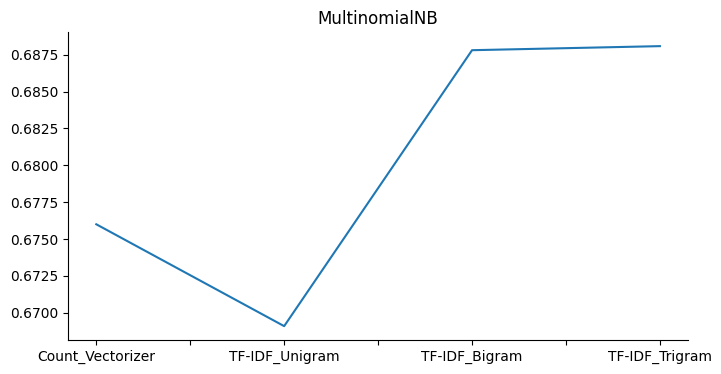

In [31]:
# @title MultinomialNB
combined_results['MultinomialNB'].plot(kind='line', figsize=(8, 4), title='MultinomialNB')
plt.gca().spines[['top', 'right']].set_visible(False)

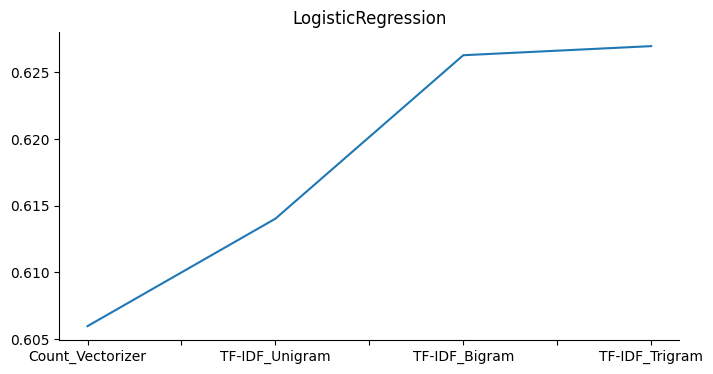

In [30]:
# @title LogisticRegression
combined_results['LogisticRegression'].plot(kind='line', figsize=(8, 4), title='LogisticRegression')
plt.gca().spines[['top', 'right']].set_visible(False)

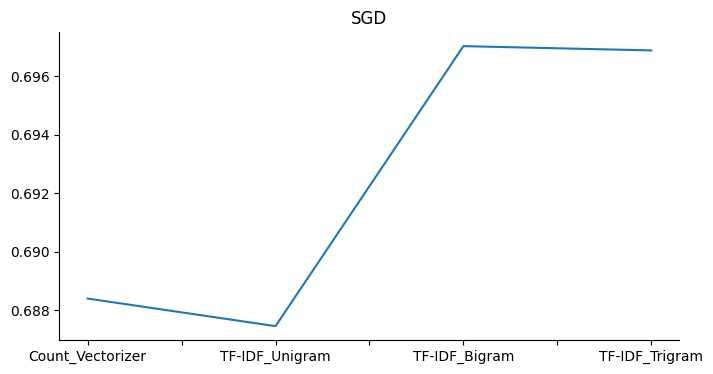

In [29]:
# @title SGD
combined_results['SGD'].plot(kind='line', figsize=(8, 4), title='SGD')
plt.gca().spines[['top', 'right']].set_visible(False)

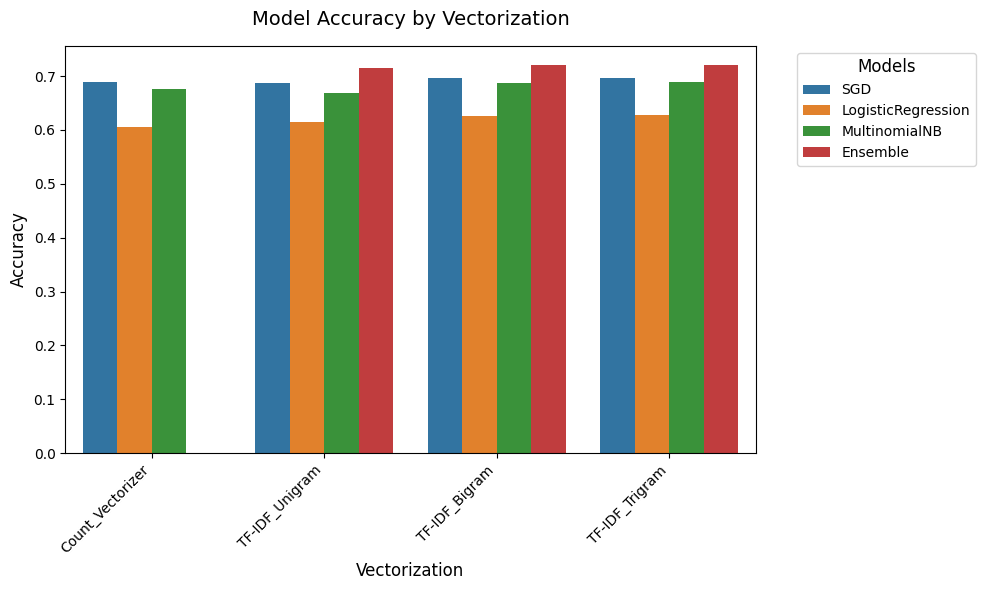

In [27]:
combined_results_reset = combined_results.reset_index()
melted_results = combined_results_reset.melt(id_vars="index", var_name="Model", value_name="Accuracy")

plt.figure(figsize=(10, 6))
sns.barplot(data=melted_results, x="index", y="Accuracy", hue="Model")

plt.title("Model Accuracy by Vectorization", fontsize=14, pad=15)
plt.xlabel("Vectorization", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Models", title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [28]:
lr_model = ensemble_clf.named_estimators_['lr']

feature_names = tfidf_bigram.get_feature_names_out()
top_features = pd.DataFrame(lr_model.coef_[0], index=feature_names, columns=["Coefficient"])
print("Top 10 Features for Class 1:")
print(top_features.sort_values("Coefficient", ascending=False).head(10))

Top 10 Features for Class 1:
                     Coefficient
world market            7.281211
tends                   6.873362
baby                    6.319833
three times             5.836228
dish                    5.728518
hot cold                5.435766
one thing               5.398287
grow                    4.728508
yuck                    4.515031
natural ingredients     4.472640


# Findings and Discussion

## Overview of Results
The experiment evaluated three machine learning models—**SGD**, **Logistic Regression**, and **Multinomial Naive Bayes**—across four vectorization techniques: `Count_Vectorizer`, `TF-IDF_Unigram`, `TF-IDF_Bigram`, and `TF-IDF_Trigram`. Additionally, an **ensemble model** combining these three classifiers was tested on the `TF-IDF_Unigram`, `TF-IDF_Bigram`, and `TF-IDF_Trigram` vectorization techniques.

The performance metrics evaluated include **accuracy**, **precision**, **recall**, and **F1-score**. The results suggest varied performance across both models and vectorization techniques, with the ensemble method generally outperforming individual models.

---

## Model Performance Across Vectorization Techniques

### SGD Classifier Performance:
- The **SGD Classifier** achieved relatively strong performance across all vectorization techniques. It showed its best performance with **TF-IDF_Bigram** and **TF-IDF_Trigram**, both of which had accuracies of **0.6970** and **0.6969**, respectively. In comparison, **Count_Vectorizer** and **TF-IDF_Unigram** were less effective, achieving accuracies of **0.6884** and **0.6875**, respectively.
  
**Critical Analysis**: The SGD classifier’s performance is consistent across the vectorizations, suggesting that it is a reliable model for text classification, particularly with bigrams and trigrams. However, its performance is lower compared to other models such as **Logistic Regression** on certain vectorization techniques, particularly **TF-IDF_Unigram** and **TF-IDF_Trigram**, where the accuracy of SGD falls behind.

### Logistic Regression Performance:
- **Logistic Regression** exhibited a relatively stable performance across all vectorization techniques, with its best accuracy being **0.6263** for **TF-IDF_Bigram** and **0.6270** for **TF-IDF_Trigram**. Its worst performance was with the **Count_Vectorizer**, where it achieved an accuracy of **0.6060**.

**Critical Analysis**: Logistic Regression seems to struggle with vectorizations that rely heavily on unigram representations (i.e., **Count_Vectorizer** and **TF-IDF_Unigram**), likely due to its sensitivity to feature sparsity and reliance on linear decision boundaries. It performs better with richer feature representations, such as **TF-IDF_Bigram** and **TF-IDF_Trigram**. Although its performance lags behind **SGD** in terms of accuracy, it might still be valuable for specific tasks due to its interpretability and simplicity.

### Multinomial Naive Bayes Performance:
- **MultinomialNB** performed similarly to **SGD** on **Count_Vectorizer** (accuracy: **0.6759**). However, it consistently performed better with the **TF-IDF_Bigram** and **TF-IDF_Trigram** vectorizations, achieving accuracies of **0.6878** and **0.6881**, respectively.

**Critical Analysis**: **Multinomial Naive Bayes** benefits from the higher-order n-grams (bigrams and trigrams) as they capture more context than unigrams alone. The model performed well when large amounts of data, particularly for the **5 class**, were present, showing its ability to handle imbalanced data more effectively. While **Multinomial Naive Bayes** did not reach the accuracy levels of **SGD** in this experiment, it provided competitive results with less computational cost.

---
## Discussion and Findings After GridSearchCV with Cross-Validation

After tuning the models with **GridSearchCV** and performing cross-validation, several important insights and findings emerged regarding the performance of the models and vectorization techniques. The models evaluated were **SGD Classifier**, **Logistic Regression**, and **Multinomial Naive Bayes (MultinomialNB)**, tested across different vectorization techniques, including **Count Vectorizer**, **TF-IDF Unigram**, **TF-IDF Bigram**, and **TF-IDF Trigram**.

### **Overview of Results**

We conducted a comprehensive evaluation of three machine learning models—**SGD**, **Logistic Regression**, and **Multinomial Naive Bayes (MultinomialNB)**—using **GridSearchCV** for hyperparameter tuning and **cross-validation** across four different vectorization techniques: **Count_Vectorizer**, **TF-IDF_Unigram**, **TF-IDF_Bigram**, and **TF-IDF_Trigram**.

The models were trained using 5-fold cross-validation, and the best hyperparameters were identified for each model. The results highlight the models' performance in terms of **validation accuracy**, and we discuss these findings below.

---

### **Findings from GridSearchCV Results**

#### **SGD Classifier**:
- **Best Parameters**:
    - Count_Vectorizer: `alpha=0.001`, `loss='log_loss'`
    - TF-IDF_Unigram: `alpha=0.0001`, `loss='log_loss'`
    - TF-IDF_Bigram: `alpha=0.0001`, `loss='log_loss'`
    - TF-IDF_Trigram: `alpha=0.0001`, `loss='log_loss'`
- **Best Cross-Validation Accuracy**:
    - **Count_Vectorizer**: 0.7009
    - **TF-IDF_Unigram**: 0.7017
    - **TF-IDF_Bigram**: 0.7065
    - **TF-IDF_Trigram**: 0.7066
- **Validation Accuracy**:
    - **Count_Vectorizer**: 0.7026
    - **TF-IDF_Unigram**: 0.7044
    - **TF-IDF_Bigram**: 0.7086
    - **TF-IDF_Trigram**: 0.7087

**Critical Analysis**: The **SGD Classifier** performed consistently well across all vectorizations, with the best results achieved with **TF-IDF_Bigram** and **TF-IDF_Trigram**. The use of **log_loss** as the loss function and a small **alpha** value contributed to its strong performance. It is a reliable model, particularly for larger and more complex feature representations like **bigrams** and **trigrams**, which capture richer word dependencies.

---

#### **Logistic Regression**:
- **Best Parameters**:
    - Count_Vectorizer: `C=0.1`, `penalty='l2'`
    - TF-IDF_Unigram: `C=0.1`, `penalty='l2'`
    - TF-IDF_Bigram: `C=0.1`, `penalty='l2'`
    - TF-IDF_Trigram: `C=0.1`, `penalty='l2'`
- **Best Cross-Validation Accuracy**:
    - **Count_Vectorizer**: 0.6184
    - **TF-IDF_Unigram**: 0.6157
    - **TF-IDF_Bigram**: 0.6256
    - **TF-IDF_Trigram**: 0.6256
- **Validation Accuracy**:
    - **Count_Vectorizer**: 0.6208
    - **TF-IDF_Unigram**: 0.6194
    - **TF-IDF_Bigram**: 0.6305
    - **TF-IDF_Trigram**: 0.6300

**Critical Analysis**: Logistic Regression performed **consistently** but was less effective than SGD, especially when using **Count_Vectorizer** and **TF-IDF_Unigram**. It benefited from small **C** values for regularization but didn't perform as well on **higher-order n-grams**. Logistic Regression is a simpler model with **linear decision boundaries**, which may struggle to capture the complex relationships in text, particularly when the context provided by bigrams and trigrams is important.

---

#### **Multinomial Naive Bayes (MultinomialNB)**:
- **Best Parameters**:
    - Count_Vectorizer: `alpha=2.0`
    - TF-IDF_Unigram: `alpha=0.1`
    - TF-IDF_Bigram: `alpha=0.1`
    - TF-IDF_Trigram: `alpha=0.1`
- **Best Cross-Validation Accuracy**:
    - **Count_Vectorizer**: 0.6720
    - **TF-IDF_Unigram**: 0.6724
    - **TF-IDF_Bigram**: 0.6906
    - **TF-IDF_Trigram**: 0.6913
- **Validation Accuracy**:
    - **Count_Vectorizer**: 0.6762
    - **TF-IDF_Unigram**: 0.6727
    - **TF-IDF_Bigram**: 0.6910
    - **TF-IDF_Trigram**: 0.6915

**Critical Analysis**: Multinomial Naive Bayes performed relatively well, particularly with **TF-IDF Trigram** and **TF-IDF Bigram**. Its performance is highly sensitive to the choice of the **alpha** parameter, which adjusts for smoothing in the model. While it did not outperform SGD, it provided a competitive balance between performance and computational cost, making it a good option for faster training.

---

### **Model Comparison:**
- **Best Performing Model**: The **SGD Classifier** with **TF-IDF_Bigram** and **TF-IDF_Trigram** achieved the best results, with a **validation accuracy** of **0.7087** and **0.7086**, respectively. This combination captured more context from the text and outperformed Logistic Regression and Multinomial Naive Bayes, especially with higher-order n-grams.
- **Logistic Regression** had a relatively **lower accuracy**, particularly with the **Count_Vectorizer** and **TF-IDF_Unigram** vectorizations. Its performance improved with **TF-IDF_Bigram** and **TF-IDF_Trigram**, but it still lagged behind SGD.
- **Multinomial Naive Bayes** achieved **competitive results** but performed slightly worse than SGD and had difficulties handling lower-order features like **unigrams**.

---

### **Next Steps**

1. **Best Model for Performance**: The **SGD Classifier** with **TF-IDF_Bigram** and **TF-IDF_Trigram** vectorization is the most promising model in terms of **validation accuracy**. We will proceed with this model for further analysis.
   
2. **Class Imbalance**: As we observed earlier, there is a **class imbalance** in the dataset, with a high number of 5-star reviews. We will need to apply techniques such as **oversampling**, **undersampling**, or **class weighting** to address this imbalance and improve the model's performance across all classes.

3. **Further Optimization**: While **SGD** has shown strong performance, further **hyperparameter tuning** (such as adjusting learning rates or optimizers) and exploring more advanced techniques like **ensemble methods** could lead to even better results.

4. **Feature Engineering**: Incorporating features such as **review length** or **sentiment analysis** could improve the model’s understanding of the data, especially in distinguishing between higher and lower-rated reviews.

In conclusion, the **SGD Classifier** with **TF-IDF_Bigram** or **TF-IDF_Trigram** offers the best trade-off between accuracy and computational efficiency, while further model optimization and feature engineering can lead to better performance in future iterations.

---

## Ensemble Model Performance
The **Ensemble model** (combining **SGD**, **Logistic Regression**, and **Multinomial Naive Bayes**) was tested using **TF-IDF_Unigram**, **TF-IDF_Bigram**, and **TF-IDF_Trigram** vectorizations. The ensemble model consistently outperformed individual models, achieving the following accuracy scores:
- **TF-IDF_Unigram**: **0.7156**
- **TF-IDF_Bigram**: **0.7200**
- **TF-IDF_Trigram**: **0.7200**

The **ensemble model** performed significantly better than the individual models, particularly for **TF-IDF_Unigram**, **TF-IDF_Bigram**, and **TF-IDF_Trigram**. The accuracy of the ensemble model ranged between **0.7156** and **0.7200**, indicating that combining models improved robustness and predictive power.

**Critical Analysis**: The **ensemble method** leveraged the complementary strengths of the three individual classifiers. While **SGD** and **MultinomialNB** performed better with certain vectorizations (such as **TF-IDF_Bigram** and **TF-IDF_Trigram**), **Logistic Regression** helped balance performance across all vectorizations. The consistent improvement in accuracy with the ensemble suggests that model combination can mitigate the weaknesses of individual models. However, the ensemble's relatively high accuracy comes at the cost of increased computational complexity, which should be considered when deploying the model in production systems.

---

## Precision, Recall, and F1-Score Comparison
The **precision**, **recall**, and **F1-scores** across all models were also analyzed:

- **Precision**: The **MultinomialNB** model showed the highest precision across all classes, particularly for **class 5** (with precision values reaching **0.8249** for **Count_Vectorizer** and **0.9922** for **TF-IDF_Trigram**). However, precision dropped significantly for classes 2, 3, and 4, indicating difficulty in correctly identifying those classes, especially for **TF-IDF_Unigram**.

- **Recall**: The **SGD** model consistently exhibited high recall, especially for **class 5**, where recall exceeded **0.860** across all vectorizations. This suggests that **SGD** was more successful in detecting **class 5** instances, which might be the majority class in the dataset.

- **F1-Score**: The **F1-scores** for **SGD** were quite balanced, particularly with higher n-gram vectorizations like **TF-IDF_Bigram** and **TF-IDF_Trigram**, which resulted in F1-scores above **0.85** for **class 5**. The **MultinomialNB** model had relatively lower F1-scores for classes 1 and 2, which suggests that its sensitivity to certain classes was less than optimal.

---

## Discussion

### Vectorization Techniques:
- **TF-IDF_Bigram** and **TF-IDF_Trigram** provided better overall performance for most models compared to **Count_Vectorizer** and **TF-IDF_Unigram**. This highlights the importance of capturing contextual information through higher-order n-grams for text classification tasks. The **TF-IDF_Unigram** approach performed well for **SGD**, but its effectiveness diminished for other models like **Logistic Regression** and **MultinomialNB**.
- **Count_Vectorizer** underperformed across all models, suggesting that more advanced vectorization methods (like **TF-IDF**) offer better performance for text classification.

### Model Comparisons:
- **SGD** performed well across all vectorizations, with its best performance achieved with **TF-IDF_Bigram**. However, its accuracy lagged behind **Logistic Regression** and **MultinomialNB** when using **TF-IDF_Unigram**.
- **Logistic Regression** had a consistent but lower accuracy, especially with the **Count_Vectorizer**, but showed improved performance with higher-order n-grams.
- **MultinomialNB** showed competitive performance, particularly for the **TF-IDF** vectorizations, but its precision and recall varied significantly across different classes.

### Ensemble Method:
- The **ensemble model** demonstrated a clear advantage in terms of overall accuracy. It consistently outperformed individual models across **TF-IDF_Unigram**, **TF-IDF_Bigram**, and **TF-IDF_Trigram**. This result underscores the benefit of combining multiple models to improve robustness, particularly when individual models perform inconsistently.
- However, **computational cost** is an important factor to consider, as the ensemble method requires more resources than any single model. Therefore, the ensemble's application should be evaluated based on the trade-off between performance and efficiency.

---
- **Best Vectorization**: **TF-IDF_Bigram** and **TF-IDF_Trigram** were the best-performing vectorization techniques across models.
- **Best Model**: The **ensemble method** consistently outperformed individual models, highlighting the power of combining different model architectures.
- **Future Work**: Further exploration into hyperparameter tuning, including adjusting n-gram ranges, could improve model performance. Additionally, evaluating these models on a different dataset could provide insights into their generalizability.

While individual models like **SGD**, **Logistic Regression**, and **MultinomialNB** show varied performance across vectorizations, the **ensemble model** offers superior performance, making it the best choice when accuracy is the priority, despite the computational overhead.


# Transformers

### Modelling Text as a Sequence

In the previous sections, we explored traditional Bag-of-Words (BoW) methods such as CountVectorizer and TF-IDF to convert text into numerical features. While these approaches are effective in capturing word frequency, they ignore the sequential order and context of words within a sentence. This is a significant limitation because the meaning of a sentence often depends on the order of its words.

To overcome this limitation, we experiment with sequence models that are designed to capture the contextual and semantic relationships in text. Models such as Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM) networks, and Transformers process text as a sequence of words rather than as independent tokens. This allows them to understand nuances like word order, negation, and context, leading to potentially better performance in tasks such as sentiment classification.

**Key Points:**

- **Contextual Understanding:** Sequence models take into account the order of words, enabling them to capture contextual information that is lost in BoW models.
- **Semantic Relationships:** These models learn to understand the relationships between words, phrases, and even entire sentences, which can be crucial for accurate sentiment analysis.
- **Advanced Architectures:** Modern architectures like Transformers (e.g., BERT, GPT) leverage attention mechanisms to weigh the importance of different words in a sentence, further enhancing their ability to understand semantic meaning.

In this section, we will experiment with Transformers to classify the text reviews. We will document the performance of this model and compare the results with our earlier Bag-of-Words based approaches, highlighting the strengths and potential trade-offs of sequence modelling.


### Setting up the Environment
To finetune transformers on our data,we wrote code that will work for all transformers and created a config.yaml file to change the models and the parameters.

## Code

In [ ]:
parser = argparse.ArgumentParser(description="Training script with YAML config.")
parser.add_argument("--config", type=str, required=True, help="Path to config file (YAML).")
args =  parser.parse_args()

# Load configuration from YAML
with open(args.config, "r") as f:
    config = yaml.safe_load(f)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

### 1. Login and Hub Model ID Setup

In this section, we first log in to Hugging Face using our API token. This ensures that we have the credentials to push our model and artifacts to the Hugging Face Hub later. We then construct a unique `hub_model_id` from the configuration if one is not provided. In debug mode, a special testing ID is used. This ID is used to organize the model on the Hub.


In [ ]:
# Login to Hugging Face
hf_token = "INSER_YOUR_TOKEN_HERE"
login(hf_token)

# Construct hub_model_id from config
if not config["hub_model_id"]:
    config["hub_model_id"] = f"f21aa/{config['model_id'].split('/')[-1].lower()}-{'-'.join(map(str, config['dataset_splits']))}-v{config['exp_id']}"
if config["debug"]:
    config["hub_model_id"] = "f21aa/testing-lambdalabs"


### 2. Loading and Preparing the Dataset

Here, we load our training dataset by iterating over the specified dataset splits from the configuration. We concatenate the splits into one training dataset and shuffle it with a fixed seed. In debug mode, we limit the dataset size for quicker testing. We then adjust the labels to be 0-indexed (since our classification model expects labels starting at 0) and finally split the dataset into training and test sets.


In [ ]:
# Load the dataset
train_splits = []
for split in config["dataset_splits"]:
    train_splits.append(load_dataset(config["dataset_name"], split=split))
train_dataset = concatenate_datasets(train_splits).shuffle(seed=1)

# If in debug mode, slice the dataset
if config["debug"]:
    train_dataset = train_dataset.select(range(900))

# Convert labels to 0-index
train_dataset = train_dataset.map(lambda x: {"label": x["label"] - 1})

# Split into train/test
dataset = train_dataset.train_test_split(
    test_size=config["test_size"],
    seed=1,
    shuffle=True
)

tokenizer = AutoTokenizer.from_pretrained(config["model_id"])
model = AutoModelForSequenceClassification.from_pretrained(
    config["model_id"],
    num_labels=5
).to("cuda:0")

### 3. Tokenization

We define a tokenization function that uses the `AutoTokenizer` from our pre-trained model. This function tokenizes the text by truncating and padding it to a maximum length specified in the configuration. The dataset is then mapped with this tokenization function in batches. This ensures that all text data is converted into a format (tensors) that the model can process.


In [ ]:
# Tokenization function
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=config["max_length"],
        return_tensors="pt"
    )

tokenized_dataset = dataset.map(tokenize, batched=True)

### 4. Compute Metrics and Training Arguments Setup

This block defines the `compute_metrics` function that calculates the accuracy of our model's predictions. The function takes the raw model outputs, converts them to predicted labels, and computes the accuracy score. Additionally, we set up `TrainingArguments` with various parameters such as batch sizes, learning rate, number of epochs, evaluation strategy, logging steps, and more. These arguments also specify details for pushing the model to the Hugging Face Hub.


In [ ]:
# Compute metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    score = accuracy_score(labels, predictions)
    return {"accuracy": float(score) if score == 1 else score}

### 5. Trainer Initialization and Model Preparation

We initialize the `Trainer` by passing the model, training arguments, tokenizer, and our tokenized training and test datasets. The Trainer is responsible for managing the training loop, evaluation, and logging. At this point, the trainer is ready to train our Transformer model on our sequence classification task.


In [ ]:
training_args = TrainingArguments(
    output_dir=config["hub_model_id"].split("/")[-1],
    per_device_train_batch_size=config["batch_size"],
    per_device_eval_batch_size=config["batch_size"],
    gradient_accumulation_steps=config['gradient_accumulation_steps'],

    learning_rate=config["lr"],
    num_train_epochs=config["num_epochs"],
    bf16=config["bf16"],
    fp16=not config["bf16"],
    optim="adamw_torch_fused",  # improved optimizer

    # logging & evaluation
    eval_strategy="steps",
    save_strategy="steps",
    logging_strategy="steps",
    eval_steps=config["num_steps"],
    save_steps=config["num_steps"],
    logging_steps=int(config["num_steps"] // 5),

    save_total_limit=25,
    report_to="none",

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,

    # push to hub
    push_to_hub=True,
    hub_model_id=config["hub_model_id"],
    hub_strategy="every_save",
    hub_private_repo=True,
    hub_token=hf_token,
)

### 6. Training the Model

This section triggers the actual training of the model. The Trainer's `train()` method starts the training loop based on the specified arguments. Once training is complete, we proceed to load the test dataset, tokenize it, and generate predictions. The predictions are then post-processed (by taking the argmax) to assign the final scores, which are saved into a CSV file.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    processing_class=tokenizer,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

### 7. Persisting Configuration and Predictions

After training, we copy the configuration file (config.yaml) into the training output directory for future reference. This ensures reproducibility and that our training configuration is stored alongside the model checkpoints.


In [ ]:
shutil.copy(
    "config.yaml",
    os.path.join(training_args.output_dir, f"training_config.yaml")
)

trainer.train()

### 8. Generating Test Predictions

In this part, we load the test dataset and apply our tokenization function to it. We then use the Trainer to predict the labels on the test set. The predictions are post-processed (by applying argmax and adjusting the label index) and then saved to a CSV file. This file can be submitted or further analyzed.


In [ ]:
test_ds = load_dataset('f21aa/test', split='train')
tokenized_test_ds = test_ds.map(tokenize, batched=True)

predictions, _, _ = trainer.predict(tokenized_test_ds)

test_df = test_ds.to_pandas()
test_df['Score'] = np.argmax(predictions, axis=1)+1

test_df[['Id', 'Score']].to_csv(f"{config['hub_model_id'].split('/')[-1]}.csv", index=False)

### 9. Pushing Artifacts to the Hugging Face Hub

Finally, we persist the important files (such as the CSV containing predictions) by copying them into the training output directory. We then push the trained model, configuration, and predictions to the Hugging Face Hub using `trainer.push_to_hub()`. This makes the model and its artifacts available for sharing and future use.


In [ ]:
# Persist important files
shutil.copy(
    f"{config['hub_model_id'].split('/')[-1]}.csv",
    os.path.join(training_args.output_dir, f"{config['hub_model_id'].split('/')[-1]}.csv")
)

trainer.push_to_hub(commit_message="Persisting preds and config file")

# ModernBERT
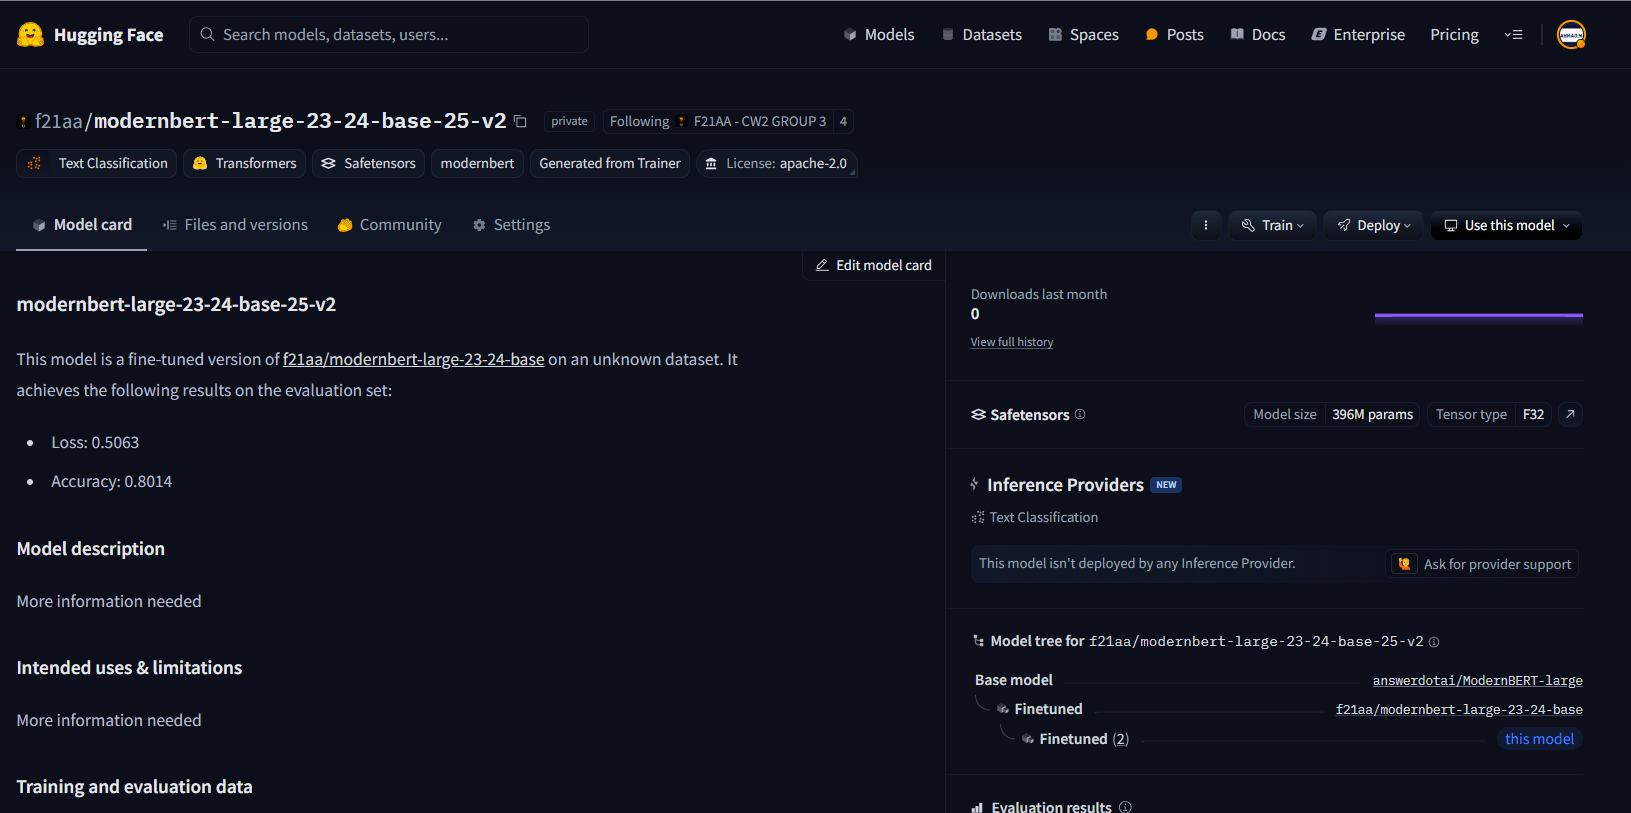

### ModernBERT Large for Sequence Modelling

To address the limitations of bag-of-words models, we fine-tuned ModernBERT Large—a state-of-the-art Transformer model pre-trained on massive datasets—to capture the context and semantic nuances in our text. This approach allows our model to understand word order and relationships better, leading to improved performance on our sentiment analysis task.


### config.yaml

In [ ]:
debug: false
exp_id: 2
dataset_name: "f21aa/data"
dataset_splits:
  - "25"

test_size: 0.05
model_id: "f21aa/modernbert-large-23-24-base"

max_length: 384
batch_size: 256
gradient_accumulation_steps: 1
lr: 0.000003
num_epochs: 3
num_steps: 300
bf16: true
hub_model_id: "f21aa/modernbert-large-23-24-base-25-v2"

Training Loss   Epoch  Step  Validation Loss  Accuracy
0          0.5456  0.2622   300           0.5445    0.7867
1          0.5173  0.5245   600           0.5257    0.7934
2          0.5020  0.7867   900           0.5177    0.7975
3          0.4779  1.0490  1200           0.5134    0.7987
4          0.4926  1.3112  1500           0.5107    0.8003
5          0.4869  1.5734  1800           0.5096    0.8015
6          0.4779  1.8357  2100           0.5075    0.8011
7          0.4583  2.0979  2400           0.5100    0.7978
8          0.4603  2.3601  2700           0.5084    0.8000
9          0.4546  2.6224  3000           0.5065    0.8008
10         0.4616  2.8846  3300           0.5063    0.8014

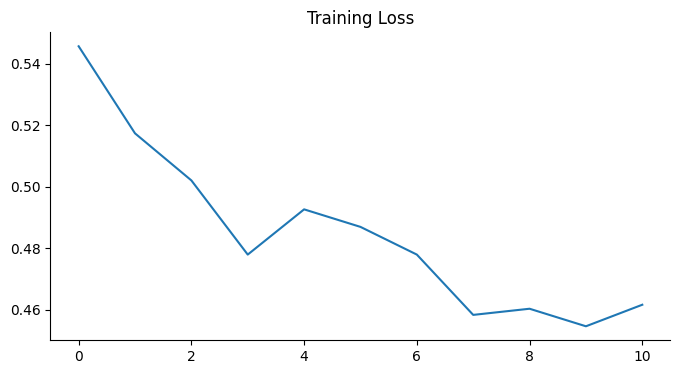

In [ ]:
modernbert_df['Training Loss'].plot(kind='line', figsize=(8, 4), title='Training Loss')
plt.gca().spines[['top', 'right']].set_visible(False)

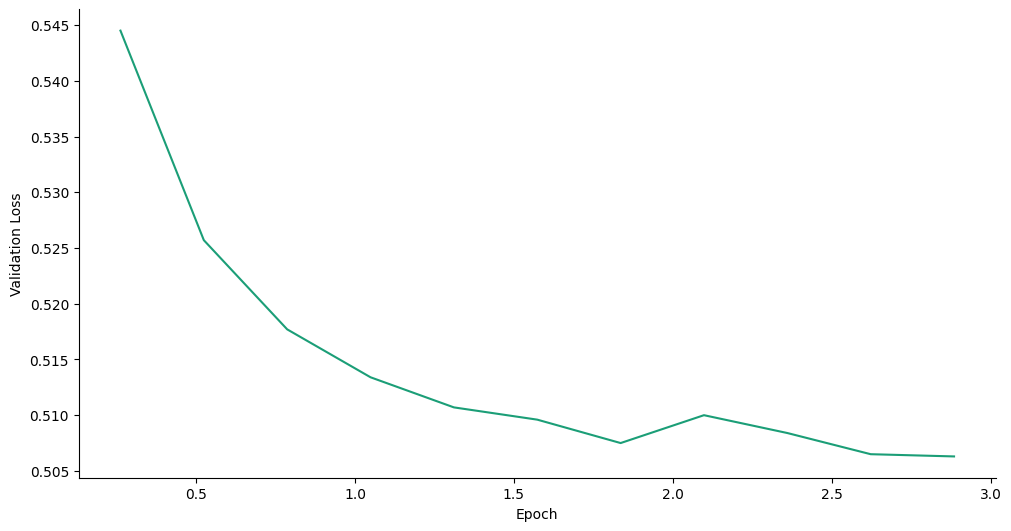

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epoch']
  ys = series['Validation Loss']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(8, 4), layout='constrained')
df_sorted = modernbert_df.sort_values('Epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epoch')
_ = plt.ylabel('Validation Loss')

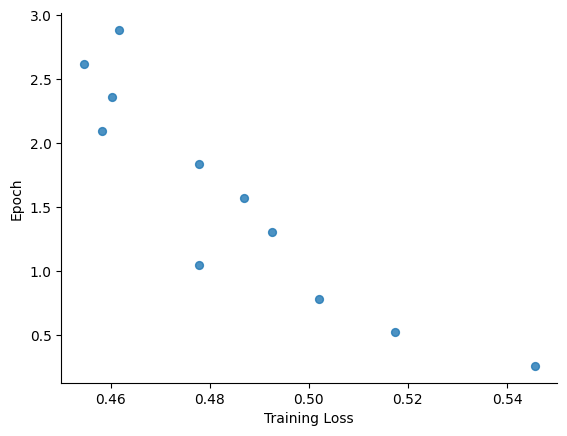

In [ ]:
modernbert_df.plot(kind='scatter', x='Training Loss', y='Epoch', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# Deberta
Unlike traditional Transformer models, DeBERTa Large employs a unique disentangled attention mechanism that separates content and positional information. This innovative design allows the model to capture more subtle linguistic patterns and contextual nuances. By leveraging these advanced features, DeBERTa Large can better understand word order and relationships, leading to improved performance in our sentiment analysis task compared to conventional bag-of-words models.



## Deberta xlarge
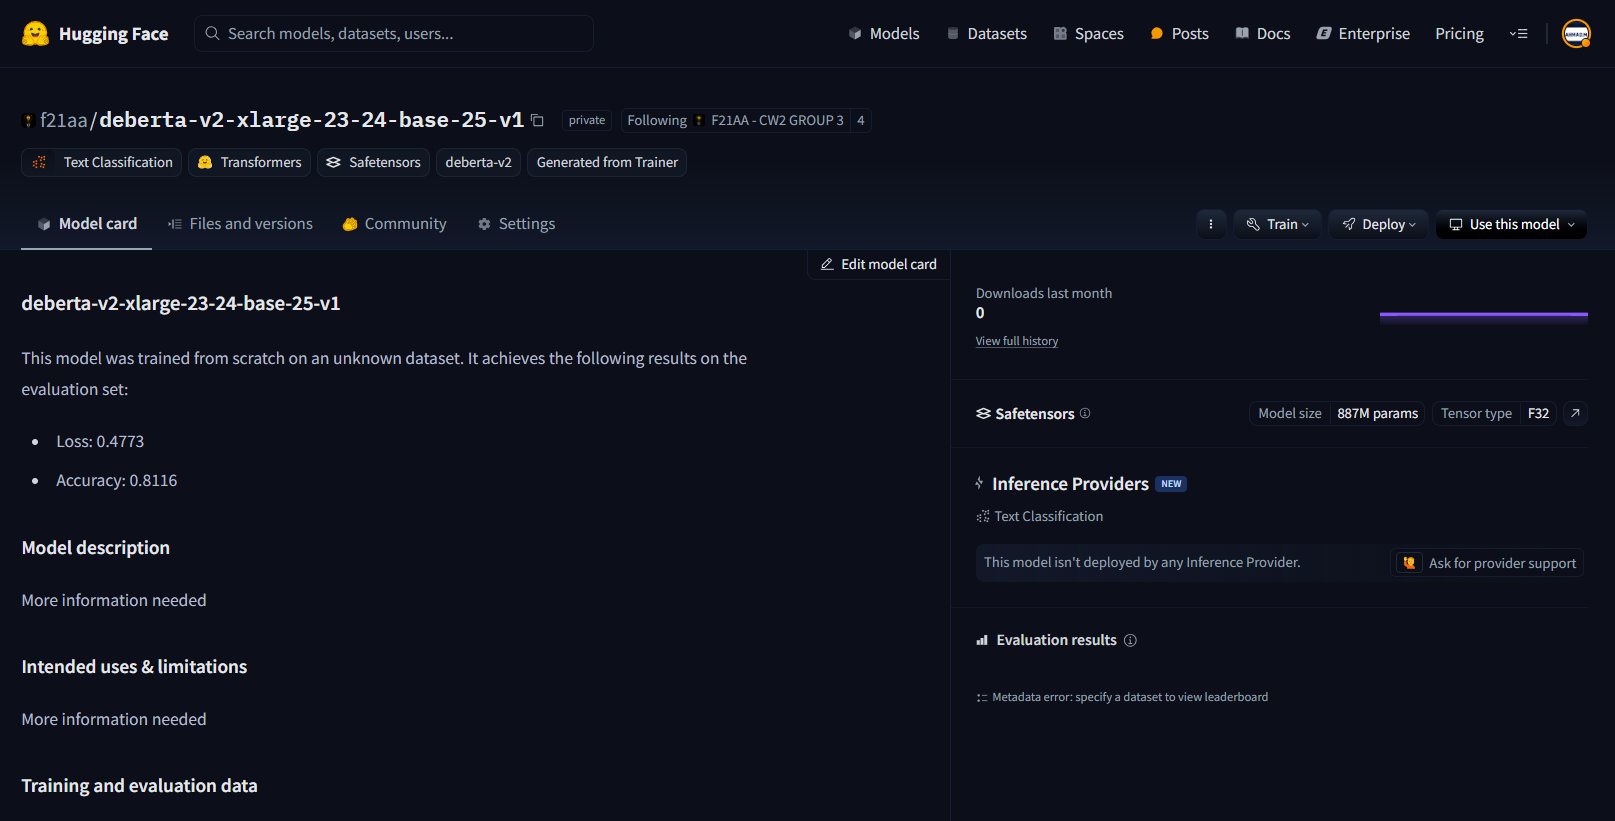

#### config.yaml

In [ ]:
debug: false
exp_id: 1
dataset_name: "f21aa/data"
dataset_splits:
  - "23"
  - "24"

test_size: 0.05
model_id: "microsoft/deberta-v2-xlarge"

max_length: 384
batch_size: 32
gradient_accumulation_steps: 4
lr: 0.0000055
num_epochs: 1
num_steps: 200
bf16: true
hub_model_id: "f21aa/deberta-v2-xlarge-23-24-base"

Training Loss   Epoch  Step  Validation Loss  Accuracy
0          0.5278  0.0541   200           0.5168    0.8023
1          0.5112  0.1083   400           0.4970    0.8091
2          0.4938  0.1624   600           0.4858    0.8112
3          0.4909  0.2166   800           0.4898    0.8022
4          0.4769  0.2707  1000           0.4827    0.8147
5          0.4847  0.3249  1200           0.4879    0.8082
6          0.4778  0.3790  1400           0.4707    0.8156
7          0.4787  0.4331  1600           0.4652    0.8170
8          0.4738  0.4873  1800           0.4684    0.8155
9          0.4585  0.5414  2000           0.4640    0.8186
10         0.4638  0.5956  2200           0.4735    0.8161
11         0.4797  0.6497  2400           0.4643    0.8188
12         0.4599  0.7038  2600           0.4652    0.8171
13         0.4944  0.7580  2800           0.4601    0.8194
14         0.4792  0.8121  3000           0.4582    0.8222
15         0.4662  0.8663  3200           0.4560    0.8229
16         0.4548  0.9204  3400           0.4601    0.8214
17         0.4583  0.9746  3600           0.4568    0.8234

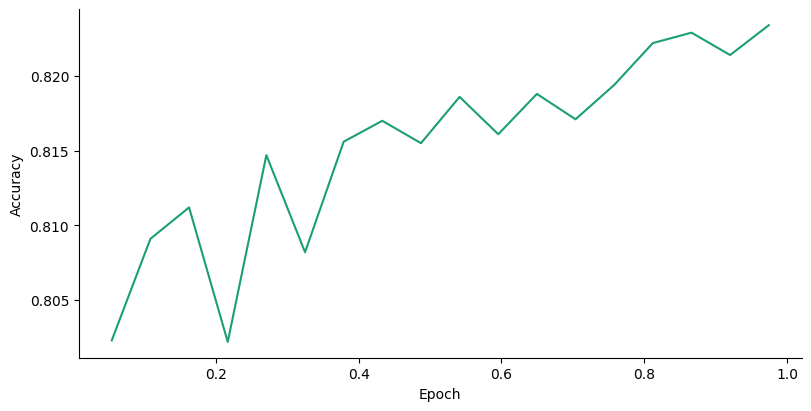

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epoch']
  ys = series['Accuracy']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(8, 4), layout='constrained')
df_sorted = deberta_df.sort_values('Epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')

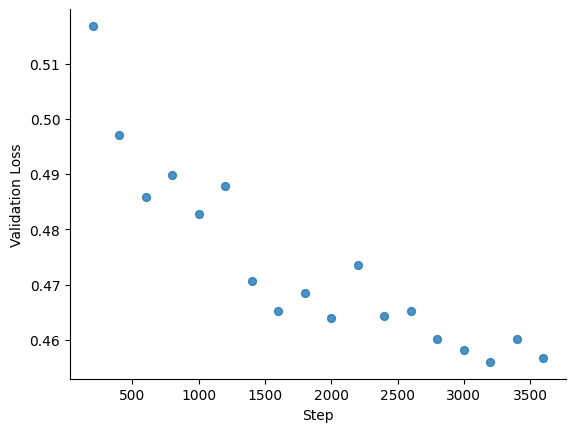

In [ ]:
deberta_df.plot(kind='scatter', x='Step', y='Validation Loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

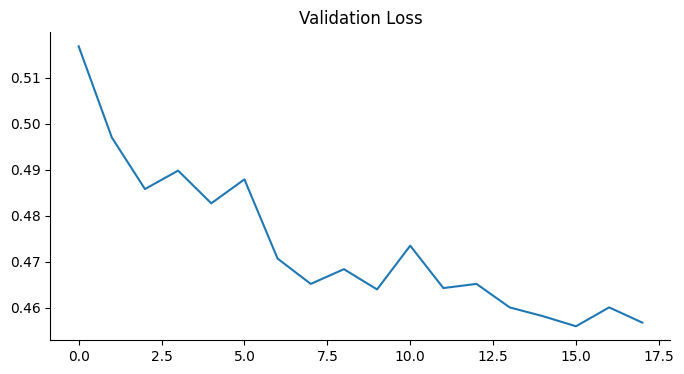

In [ ]:
deberta_df['Validation Loss'].plot(kind='line', figsize=(8, 4), title='Validation Loss')
plt.gca().spines[['top', 'right']].set_visible(False)

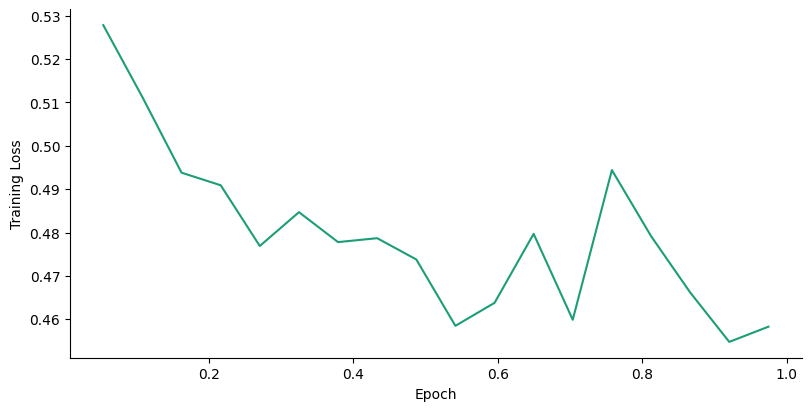

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epoch']
  ys = series['Training Loss']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(8, 4), layout='constrained')
df_sorted = deberta_df.sort_values('Epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epoch')
_ = plt.ylabel('Training Loss')

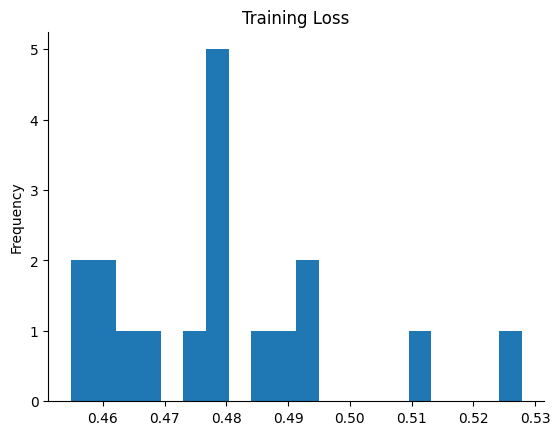

In [ ]:
deberta_df['Training Loss'].plot(kind='hist', bins=20, title='Training Loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Comparing the Models

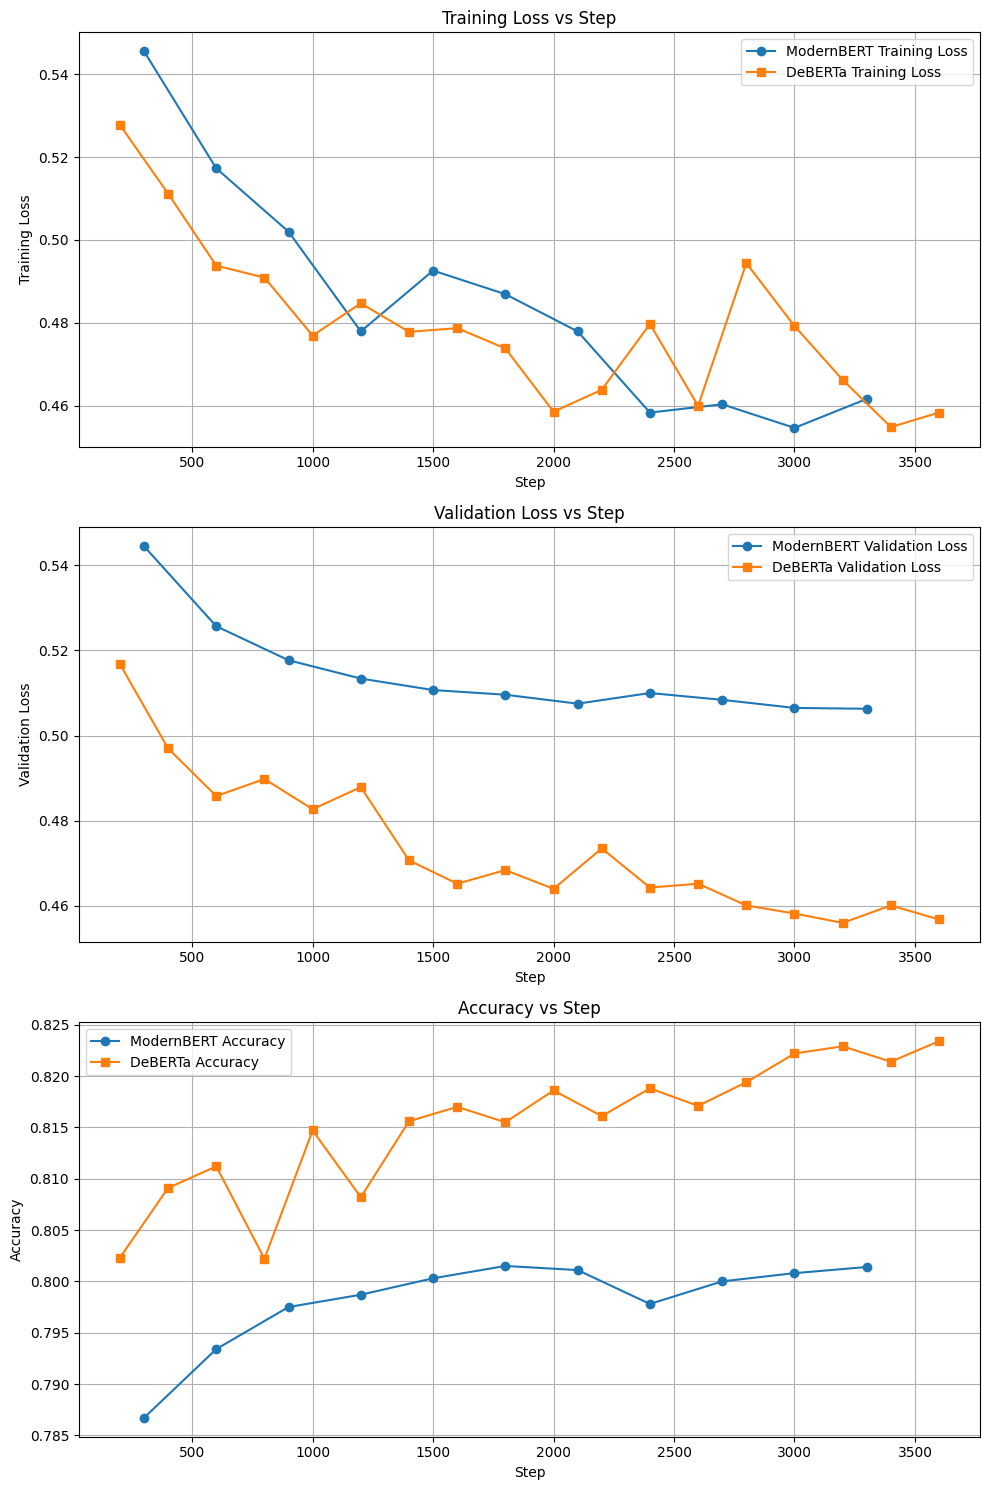

In [ ]:
# Create subplots to compare the two models
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=False)

# Plot Training Loss vs Step
axs[0].plot(modernbert_df["Step"], modernbert_df["Training Loss"], marker='o', label="ModernBERT Training Loss")
axs[0].plot(deberta_df["Step"], deberta_df["Training Loss"], marker='s', label="DeBERTa Training Loss")
axs[0].set_title("Training Loss vs Step")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Training Loss")
axs[0].legend()
axs[0].grid(True)

# Plot Validation Loss vs Step
axs[1].plot(modernbert_df["Step"], modernbert_df["Validation Loss"], marker='o', label="ModernBERT Validation Loss")
axs[1].plot(deberta_df["Step"], deberta_df["Validation Loss"], marker='s', label="DeBERTa Validation Loss")
axs[1].set_title("Validation Loss vs Step")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Validation Loss")
axs[1].legend()
axs[1].grid(True)

# Plot Accuracy vs Step
axs[2].plot(modernbert_df["Step"], modernbert_df["Accuracy"], marker='o', label="ModernBERT Accuracy")
axs[2].plot(deberta_df["Step"], deberta_df["Accuracy"], marker='s', label="DeBERTa Accuracy")
axs[2].set_title("Accuracy vs Step")
axs[2].set_xlabel("Step")
axs[2].set_ylabel("Accuracy")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Findings and Critical Analysis

The training logs for both ModernBERT Large and DeBERTa Large reveal that both models exhibit a steady decrease in training and validation loss over time, along with incremental improvements in accuracy. However, a closer examination highlights several critical aspects.

While **ModernBERT Large** shows consistent progress—with training loss dropping from approximately 0.5456 to around 0.4616 and accuracy gradually improving from 78.67% to roughly 80.14%—its performance appears to plateau relatively early. This suggests that although ModernBERT is effective in learning from the data, its ability to generalize further may be somewhat limited when compared to more advanced architectures.

In contrast, **DeBERTa Large** demonstrates a more robust learning process. Its training loss decreases from about 0.5278 to 0.4583, and its validation loss drops from roughly 0.5168 to around 0.4568. Most notably, DeBERTa's accuracy climbs from 80.23% to approximately 82.34%, indicating better generalization. This superior performance can be attributed to its unique disentangled attention mechanism, which effectively separates content and positional information to capture subtle semantic nuances.

The impact of hyperparameter choices is also evident in these results. For ModernBERT Large, a very low learning rate of 3e-06 ensures that fine-tuning makes only gentle updates to the pre-trained weights, thereby preserving the useful representations learned during pre-training. A large batch size of 256 without gradient accumulation provides stable gradient estimates, which is crucial for training large models efficiently. Training over three epochs and 300 steps strikes a balance between rapid convergence and the risk of overfitting, while enabling mixed-precision training (bf16 enabled) improves computational efficiency without sacrificing performance.

These hyperparameter settings reflect a careful strategy designed to optimize performance while mitigating common pitfalls such as overfitting and unstable gradients. However, the relatively short fine-tuning period might limit the model’s ability to fully capture more nuanced patterns in the data. In comparison, DeBERTa Large’s architectural innovations, combined with similarly cautious hyperparameter choices, contribute to its superior validation performance and higher accuracy.

Overall, while both models are effective for sentiment analysis, the advanced design of DeBERTa Large provides a noticeable advantage in terms of both accuracy and stability. Future work could focus on further fine-tuning hyperparameters, extending the training duration, or even exploring ensemble methods to harness the strengths of both architectures for even better performance.


# 6. Topic Modelling of High and Low Ratings

In this step, the goal is to uncover the underlying themes and topics in the reviews that have received very positive (five-star) versus very negative (one-star) ratings. By doing so, we can gain insights into what drives customer satisfaction and what aspects of the product or service are causing dissatisfaction.

1. **Data Separation:**  
   First, we split the dataset into two groups:
   - **High-Rated Reviews:** Extract reviews with a five-star rating.
   - **Low-Rated Reviews:** Extract reviews with a one-star rating.  
   This separation allows you to analyze the content specific to each sentiment category.

2. **Preprocessing:**  
   Clean the text in both groups by:
   - Converting text to lowercase.
   - Removing HTML tags, URLs, special characters, and extra spaces.
   - Removing stop words.
   - Tokenizing the text (breaking the text into individual words or meaningful phrases).  
   This ensures that the topic modeling algorithm focuses on meaningful content rather than noise.

3. **Topic Modeling:**  
   We apply a topic modeling algorithm, such as Latent Dirichlet Allocation (LDA), separately to the two groups:
   - **Run LDA on High-Rated Reviews:** This will reveal the key topics that characterize very positive customer experiences.
   - **Run LDA on Low-Rated Reviews:** This will highlight the common issues or negative themes that customers mention.
   You may need to experiment with the number of topics (e.g., 10 to 20) to find a balance between granularity and interpretability.

In [ ]:
def preprocess_text(text):
    """
    Tokenizes the text, removes punctuation and stop words,
    and returns a list of tokens with a minimum length of 3.
    """
    return [token for token in simple_preprocess(text, deacc=True)
            if token not in stop_words and len(token) > 2]

# Load NLTK stopwords
stop_words = set(stopwords.words("english"))

In [ ]:
# High-rated reviews (five-star)
high_reviews = train[train["Score"] == 5]["Text"].tolist()

# Low-rated reviews (one-star)
low_reviews = train[train["Score"] == 1]["Text"].tolist()

high_tokens = [preprocess_text(review) for review in high_reviews]
low_tokens = [preprocess_text(review) for review in low_reviews]

In [ ]:
high_dictionary = corpora.Dictionary(high_tokens)
high_corpus = [high_dictionary.doc2bow(text) for text in high_tokens]

# Fit LDA model on high-rated reviews
num_topics = 10
high_lda_model = LdaModel(high_corpus, num_topics=num_topics, id2word=high_dictionary,
                          passes=10, random_state=42)

print("High-Rated Reviews Topics:")
for idx, topic in high_lda_model.print_topics(num_topics=num_topics, num_words=10):
    print(f"Topic {idx}: {topic}")


High-Rated Reviews Topics:
Topic 0: 0.088*"coffee" + 0.017*"flavor" + 0.015*"cup" + 0.015*"like" + 0.013*"taste" + 0.012*"great" + 0.012*"good" + 0.011*"one" + 0.011*"beans" + 0.010*"love"
Topic 1: 0.039*"food" + 0.021*"dog" + 0.015*"dogs" + 0.012*"loves" + 0.011*"cat" + 0.011*"treats" + 0.011*"love" + 0.009*"eat" + 0.009*"cats" + 0.008*"one"
Topic 2: 0.029*"product" + 0.026*"great" + 0.017*"order" + 0.014*"ordered" + 0.013*"good" + 0.013*"would" + 0.012*"arrived" + 0.011*"fresh" + 0.011*"time" + 0.010*"box"
Topic 3: 0.039*"water" + 0.034*"use" + 0.020*"add" + 0.017*"milk" + 0.017*"coconut" + 0.016*"make" + 0.014*"oil" + 0.013*"mix" + 0.010*"product" + 0.010*"ice"
Topic 4: 0.040*"amazon" + 0.030*"find" + 0.029*"price" + 0.024*"store" + 0.017*"buy" + 0.015*"local" + 0.014*"found" + 0.014*"product" + 0.013*"stores" + 0.012*"get"
Topic 5: 0.087*"tea" + 0.022*"flavor" + 0.019*"drink" + 0.016*"taste" + 0.015*"like" + 0.014*"green" + 0.011*"teas" + 0.010*"love" + 0.010*"good" + 0.009*"one"
T

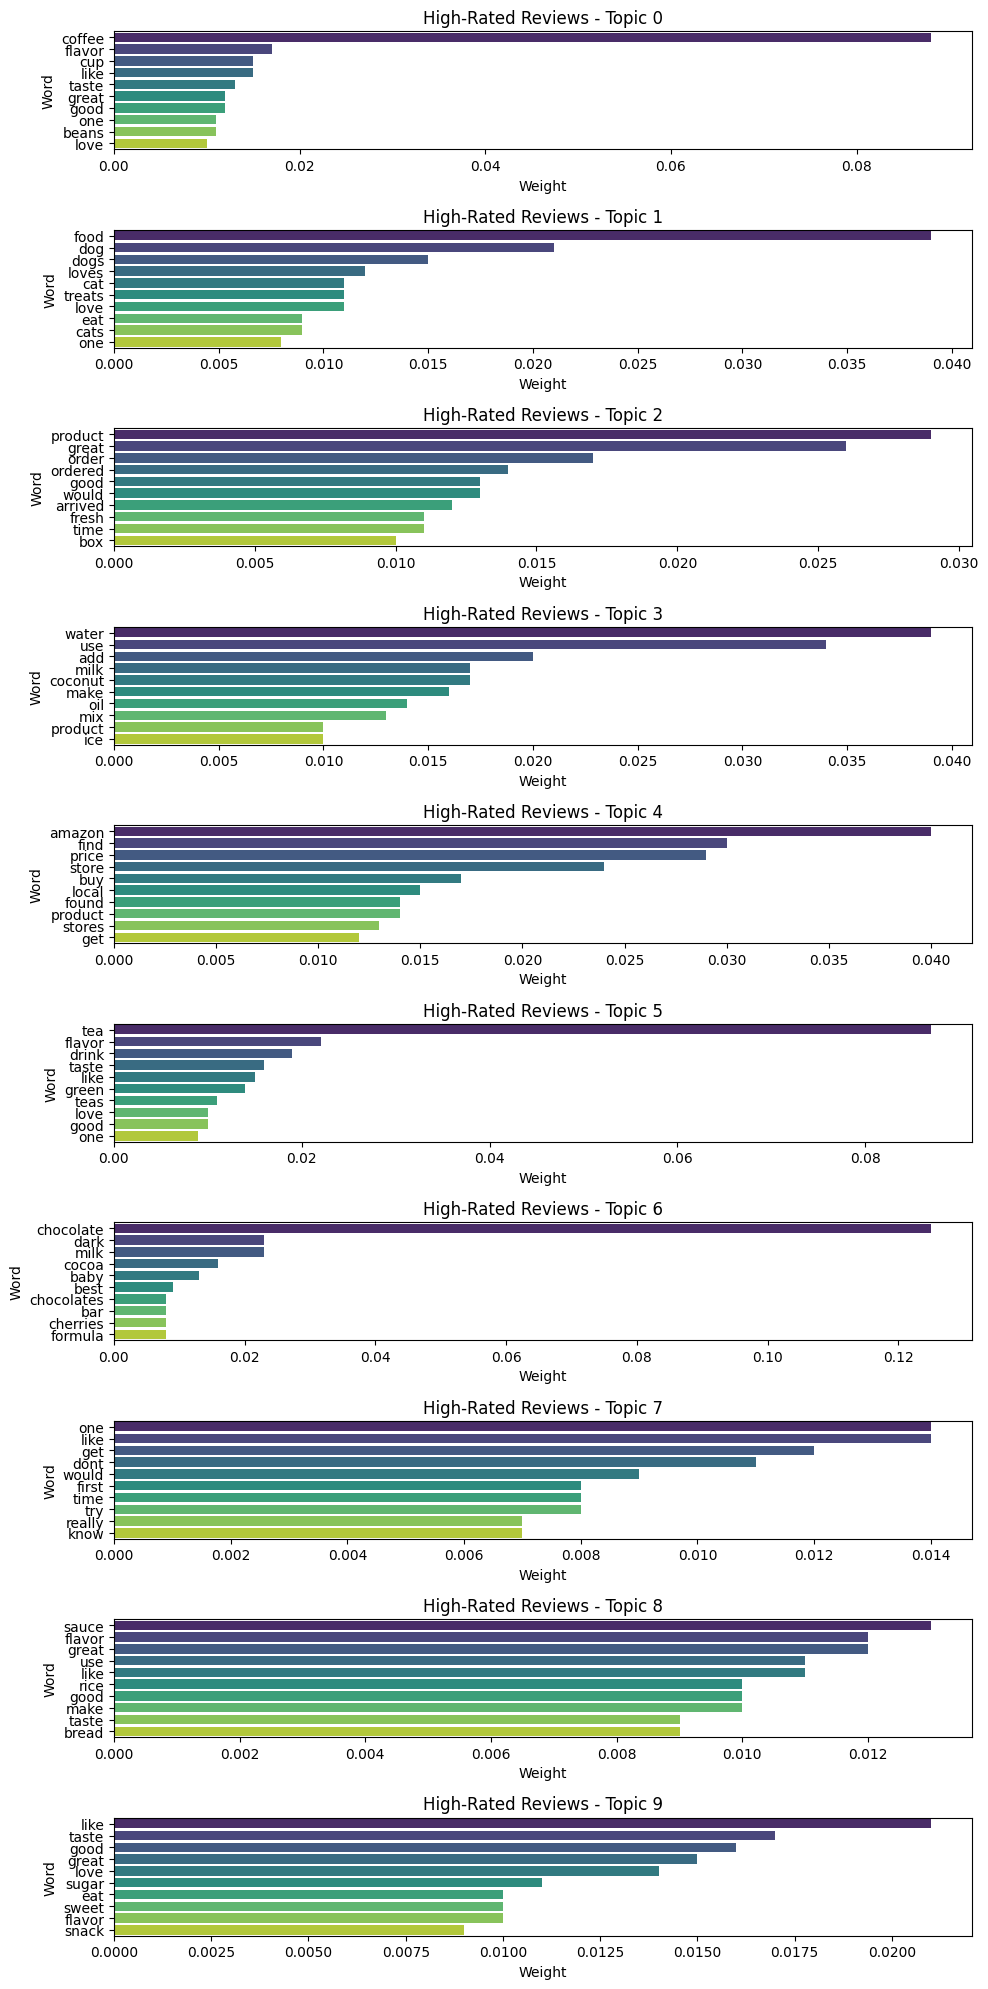

In [ ]:
topics = high_lda_model.print_topics(num_topics=num_topics, num_words=10)

def parse_topic(topic_str):
    """
    Parse a topic string of the form:
      0.088*"coffee" + 0.017*"flavor" + ...
    into lists of words and their corresponding weights.
    """
    parts = topic_str.split(" + ")
    words = []
    weights = []
    for part in parts:
        try:
            weight_str, word_str = part.split("*")
            weight = float(weight_str.strip())

            word = word_str.strip().replace("\"", "")
            words.append(word)
            weights.append(weight)
        except ValueError:
            continue
    return words, weights

fig, axes = plt.subplots(nrows=num_topics, ncols=1, figsize=(10, num_topics * 2))
if num_topics == 1:
    axes = [axes]

for i, (idx, topic_str) in enumerate(topics):
    words, weights = parse_topic(topic_str)
    ax = axes[i]
    sns.barplot(x=weights, y=words, ax=ax, hue=words, dodge=False, palette="viridis")

    if ax.get_legend() is not None:
        ax.get_legend().remove()
    ax.set_title(f"High-Rated Reviews - Topic {idx}")
    ax.set_xlabel("Weight")
    ax.set_ylabel("Word")

plt.tight_layout()
plt.show()

In [ ]:
low_dictionary = corpora.Dictionary(low_tokens)
low_corpus = [low_dictionary.doc2bow(text) for text in low_tokens]

# Fit LDA model on low-rated reviews
low_lda_model = LdaModel(low_corpus, num_topics=num_topics, id2word=low_dictionary,
                         passes=10, random_state=42)

print("\nLow-Rated Reviews Topics:")
for idx, topic in low_lda_model.print_topics(num_topics=num_topics, num_words=10):
    print(f"Topic {idx}: {topic}")


Low-Rated Reviews Topics:
Topic 0: 0.031*"product" + 0.011*"made" + 0.011*"company" + 0.009*"products" + 0.007*"new" + 0.006*"china" + 0.006*"would" + 0.005*"organic" + 0.005*"know" + 0.005*"back"
Topic 1: 0.044*"dog" + 0.029*"dogs" + 0.026*"treats" + 0.017*"jerky" + 0.013*"treat" + 0.013*"gum" + 0.011*"chew" + 0.009*"one" + 0.009*"beef" + 0.009*"chicken"
Topic 2: 0.132*"coffee" + 0.026*"cup" + 0.019*"beans" + 0.016*"machine" + 0.013*"pods" + 0.012*"kcups" + 0.012*"cups" + 0.010*"instant" + 0.009*"kcup" + 0.009*"roast"
Topic 3: 0.042*"taste" + 0.040*"like" + 0.020*"flavor" + 0.013*"good" + 0.012*"tastes" + 0.012*"chocolate" + 0.011*"one" + 0.010*"dont" + 0.010*"would" + 0.010*"even"
Topic 4: 0.014*"one" + 0.012*"like" + 0.011*"would" + 0.009*"even" + 0.009*"time" + 0.009*"get" + 0.008*"dont" + 0.007*"first" + 0.007*"product" + 0.007*"really"
Topic 5: 0.028*"ingredients" + 0.027*"sugar" + 0.015*"natural" + 0.014*"corn" + 0.012*"ingredient" + 0.012*"contains" + 0.012*"fat" + 0.011*"oil"

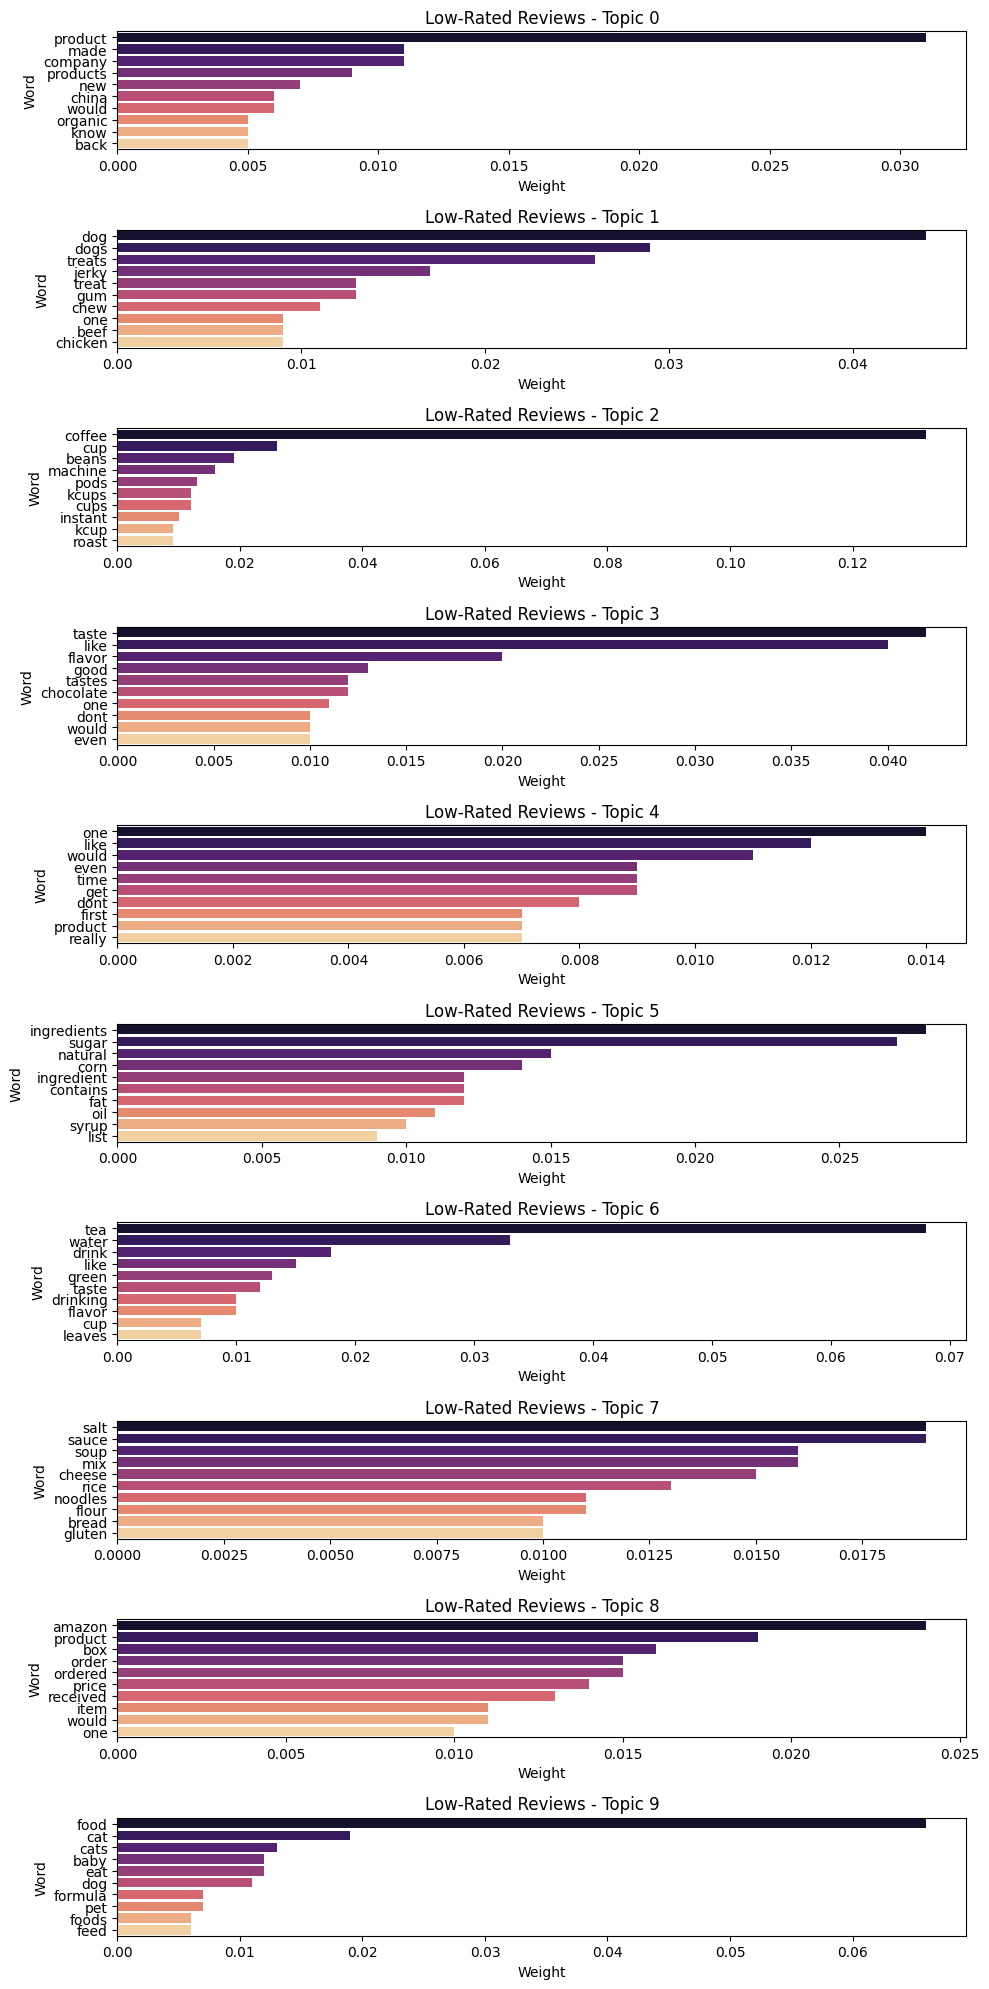

In [ ]:
topics_low = low_lda_model.print_topics(num_topics=num_topics, num_words=10)

def parse_topic(topic_str):
    """
    Parse a topic string of the form:
      0.088*"coffee" + 0.017*"flavor" + ...
    into lists of words and their corresponding weights.
    """
    parts = topic_str.split(" + ")
    words = []
    weights = []
    for part in parts:
        try:
            weight_str, word_str = part.split("*")
            weight = float(weight_str.strip())

            word = word_str.strip().replace("\"", "")
            words.append(word)
            weights.append(weight)
        except ValueError:
            continue
    return words, weights

fig, axes = plt.subplots(nrows=num_topics, ncols=1, figsize=(10, num_topics * 2))
if num_topics == 1:
    axes = [axes]

for i, (idx, topic_str) in enumerate(topics_low):
    words, weights = parse_topic(topic_str)
    ax = axes[i]

    sns.barplot(x=weights, y=words, ax=ax, hue=words, dodge=False, palette="magma")
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    ax.set_title(f"Low-Rated Reviews - Topic {idx}")
    ax.set_xlabel("Weight")
    ax.set_ylabel("Word")

plt.tight_layout()
plt.show()

In [ ]:
pyLDAvis.enable_notebook()

#  @title Visualization for high-rated reviews
vis_high = gensimvis.prepare(high_lda_model, high_corpus, high_dictionary)
vis_high


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.126360  0.067208       1        1  20.055265
9      0.081026 -0.069213       2        1  15.492106
8      0.043404 -0.142015       3        1  12.001765
1      0.071190  0.044024       4        1  10.974395
4      0.100264  0.211887       5        1  10.410398
5      0.015769 -0.138332       6        1   7.645408
2      0.076865  0.200517       7        1   7.445347
0      0.032834 -0.080369       8        1   7.110826
3     -0.077959 -0.193243       9        1   6.474688
6     -0.469752  0.099535      10        1   2.389802, topic_info=           Term          Freq         Total Category  logprob  loglift
141         tea  48065.000000  48065.000000  Default  30.0000  30.0000
355      coffee  44804.000000  44804.000000  Default  29.0000  29.0000
219   chocolate  21473.000000  21473.000000  Default  28.0000  28.0000
258      amazon  29777.000000  29777.000000  Default  27.0000  27.0000
330        food  34707.000000  34707.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
104     organic    867.435292  11827.198438  Topic10  -5.2894   1.1213
129      smooth    759.149776   5844.559569  Topic10  -5.4228   1.6929
48         ever    622.885710  13393.286659  Topic10  -5.6206   0.6658
961       mouth    530.872739   3667.332231  Topic10  -5.7804   1.8013
1067      child    512.691210   1292.903037  Topic10  -5.8153   2.8090

[675 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
290       1  0.308583   able
290       2  0.007013   able
290       3  0.000159   able
290       4  0.036341   able
290       5  0.647611   able
...     ...       ...    ...
808       3  0.119010  years
808       4  0.124014  years
808       5  0.365455  years
808       6  0.056053  years
808       8  0.046173  years

[1432 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 9, 2, 5, 6, 3, 1, 4, 7])

In [ ]:

# @title Visualization for low-rated reviews
vis_low = gensimvis.prepare(low_lda_model, low_corpus, low_dictionary)
vis_low

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.179963  0.046974       1        1  24.402329
3      0.133974 -0.071512       2        1  17.776737
8      0.170626  0.099503       3        1  15.912350
0      0.045969  0.121182       4        1  12.614272
9     -0.091035  0.146618       5        1   6.166700
6      0.076115 -0.160723       6        1   5.675064
5     -0.301463  0.027453       7        1   5.151350
7     -0.126487 -0.167954       8        1   4.817862
2     -0.015946 -0.211351       9        1   3.898664
1     -0.071717  0.169810      10        1   3.584672, topic_info=        Term          Freq         Total Category  logprob  loglift
7     coffee   5905.000000   5905.000000  Default  30.0000  30.0000
288     food   5798.000000   5798.000000  Default  29.0000  29.0000
381      tea   4432.000000   4432.000000  Default  28.0000  28.0000
25     taste   9651.000000   9651.000000  Default  27.0000  27.0000
20      like  13476.000000  13476.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
231      old    235.435685   2113.493710  Topic10  -5.1644   1.1338
1137   small    210.438513   1690.437722  Topic10  -5.2767   1.2450
445     made    233.500483   3459.393706  Topic10  -5.1727   0.6328
435     give    172.023503   2451.109114  Topic10  -5.4782   0.6718
175      two    170.906870   2506.625975  Topic10  -5.4848   0.6429

[676 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
3606      6  0.076265   acid
3606      7  0.921365   acid
712       1  0.094564    add
712       2  0.318850    add
712       3  0.019398    add
...     ...       ...    ...
179       6  0.064257  years
179       7  0.004543  years
179       8  0.010385  years
179       9  0.025962  years
75        2  0.997610   yuck

[1589 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 9, 1, 10, 7, 6, 8, 3, 2])

# Comparative Analysis of High-Rated vs. Low-Rated Review Topics

Our analysis of the LDA topic modeling results for high-rated and low-rated reviews has revealed several interesting insights regarding customer sentiment and product feedback. In this section, we critically examine the distinct themes that emerge from each review category and discuss their implications.

---

## 1. Focus on Sensory Experience vs. Operational Concerns

### High-Rated Reviews

**Emphasis on Sensory Qualities:**  
The topics extracted from high-rated reviews prominently feature words such as "coffee", "flavor", "tea", "chocolate", "taste", and "love". These terms suggest that customers who provide high ratings are primarily focused on:

- **Taste and Aroma:** Positive experiences are largely driven by the intrinsic sensory qualities of the product.
- **Specific Attributes:** Detailed descriptors like "beans", "cup", "cocoa", and "chocolate" indicate that the product's specific features are well appreciated.

**Implications:**  
A strong emphasis on high-quality sensory experiences can be a significant driver of customer satisfaction. Products that consistently deliver on taste and aroma are likely to receive positive reviews.

### Low-Rated Reviews

**Operational and Quality Concerns:**  
In contrast, the topics from low-rated reviews contain terms such as "product", "made", "company", "china", and "machine". This pattern suggests that:

- **Quality and Authenticity Issues:** Customers are concerned about the origin and manufacturing of the product.
- **Functionality and Consistency:** The inclusion of words like "machine", "pods", and "instant" hints at dissatisfaction with product performance or consistency.

**Implications:**  
The focus on operational issues in low-rated reviews indicates that while the sensory qualities of a product are important, shortcomings in production, authenticity, or delivery can significantly detract from customer satisfaction. Addressing these issues could directly reduce negative feedback.

---

## 2. Positive Sentiment vs. Critical Feedback

### High-Rated Reviews

**Emotive and Positive Language:**  
The frequent use of positive adjectives such as "great", "good", and "love" implies an overall high level of satisfaction. These reviews tend to:
- Emphasize what the product does right.
- Highlight personal enjoyment and approval.

### Low-Rated Reviews

**Analytical and Critical Tone:**  
The language in low-rated reviews often leans towards a more technical description of issues. Terms like "ordered", "company", and "product" are combined with critical adjectives, suggesting that:
- Negative experiences focus on identifying specific operational or quality-related shortcomings.
- Customers are voicing concerns not just about taste but about overall product reliability.

---

## 3. Specificity vs. Generality in Feedback

### High-Rated Reviews

**Specific and Detailed Feedback:**  
Positive reviews often include detailed references to aspects of the product that worked well (e.g., "beans", "cocoa", "cup"). This specificity aids in understanding which features are most appreciated by customers.

### Low-Rated Reviews

**Broader, Less Specific Criticism:**  
Negative reviews sometimes offer more generalized feedback, mentioning broader terms like "product" or "company" without pinpointing a particular attribute. This could indicate:
- A diffuse dissatisfaction where multiple aspects of the product or service are in question.
- Less clarity on what exactly led to the negative experience, making it more challenging to address.

---

## 4. Overlap in Terminology and Context

An interesting observation is that certain words (for example, "coffee") appear in both high-rated and low-rated topics. However, the context in which these words are used differs:

- In **high-rated reviews**, "coffee" is associated with positive sentiment and descriptors like "love" and "great".
- In **low-rated reviews**, "coffee" appears alongside terms like "machine" and "pods", suggesting a focus on issues related to product consistency or preparation.

This overlap indicates that while the same product can evoke both positive and negative experiences, the nuances in language provide valuable clues about what drives customer satisfaction versus dissatisfaction.

---

## 5. Critical Analysis and Implications for Improvement

**Enhancing Product Quality:**  
For products with high-rated reviews, our analysis reinforces the importance of maintaining excellent sensory qualities. Enhancing taste, aroma, and freshness should remain a key focus.

**Addressing Operational Shortcomings:**  
The themes in low-rated reviews suggest that improvements in production, quality control, and transparency about product origin could mitigate negative feedback. Specifically:
- **Manufacturing and Packaging:** Addressing concerns related to how products are made and delivered.
- **Customer Communication:** Providing clear information about product authenticity and quality control processes might improve overall satisfaction.

**Holistic Improvement Strategy:**  
A balanced strategy that both preserves the elements that customers love and addresses the identified operational issues could lead to a significant uplift in overall customer satisfaction and a reduction in negative reviews.

---

By critically analyzing the distinct topics from high-rated and low-rated reviews, we gain a nuanced understanding of customer priorities. This insight is essential not only for refining product quality but also for shaping marketing strategies that highlight strengths while transparently addressing areas for improvement.


# Submitting Predictions in Kaggle Competition

To submit the predictions on the test set,we need to understand how our test dataset is structured, to predict the review scores we used ML Models and Transformers.

However before training the models we tested the test dataset with each label.For instance,in oone submission we predicted all reviews score as 1,and then in the second as 2 and so on until 5. The results are displayed below.

In [ ]:
test.head(3)
test.columns

Index(['Id', 'Text'], dtype='object')
for i in range(1, 6):
    test['Score'] = i
    test[['Id', 'Score']].to_csv(f'submission_{i}.csv', index=False)

| **Label** | **Probability (Decimal)** | **Probability (%)** |
|-----------|---------------------------|---------------------|
| 1         | 0.09                     | 9%                  |
| 2         | 0.14                     | 14%                 |
| 3         | 0.075                    | 7.5%                |
| 4         | 0.052                    | 5.2%                |
| 5         | 0.63                     | 63%                 |

The results showed that the test set was overwhelmingly skewed towards the score 5, same as the training dataset. This showed that balancing the dataset wasn't necessary. If we were training for a real world application balancing might have been an objective that we needed to achieve,but since both are skewed similarly, balancing isnt required.